In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-malimg-inceptionv3-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = InceptionV3(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 8394 samples, validate on 945 samples
Epoch 1/100
8394/8394 [==============================] - 84s - loss: 0.5947 - acc: 0.8381 - val_loss: 13.7790 - val_acc: 0.0138
Epoch 2/100
8394/8394 [==============================] - 64s - loss: 0.2822 - acc: 0.9208 - val_loss: 14.8239 - val_acc: 0.0011
Epoch 3/100
8394/8394 [==============================] - 67s - loss: 0.1922 - acc: 0.9431 - val_loss: 1.5692 - val_acc: 0.6825
Epoch 4/100
8394/8394 [==============================] - 67s - loss: 0.1519 - acc: 0.9507 - val_loss: 0.8642 - val_acc: 0.8053
Epoch 5/100
8394/8394 [==============================] - 67s - loss: 0.1133 - acc: 0.9633 - val_loss: 0.2304 - val_acc: 0.8688
Epoch 6/100
8394/8394 [==============================] - 68s - loss: 0.1192 - acc: 0.9624 - val_loss: 0.5439 - val_acc: 0.9016
Epoch 7/100
8394/8394 [==============================] - 68s - loss: 0.1009 - acc: 0.9664 - val_loss: 5.1802 - val_acc: 0.1873
Epoch 8/100
8394/8394 [==============================] - 67s -

8397/8397 [==============================] - 68s - loss: 0.0638 - acc: 0.9777 - val_loss: 0.0971 - val_acc: 0.9724
Epoch 28/100
8397/8397 [==============================] - 68s - loss: 0.0693 - acc: 0.9799 - val_loss: 0.3510 - val_acc: 0.9257
Epoch 29/100
8397/8397 [==============================] - 68s - loss: 0.1536 - acc: 0.9508 - val_loss: 0.2140 - val_acc: 0.9533
Epoch 30/100
8397/8397 [==============================] - 68s - loss: 0.0793 - acc: 0.9749 - val_loss: 0.0758 - val_acc: 0.9756
Epoch 31/100
8397/8397 [==============================] - 68s - loss: 0.0634 - acc: 0.9798 - val_loss: 0.0942 - val_acc: 0.9692
Epoch 32/100
8397/8397 [==============================] - 68s - loss: 0.0641 - acc: 0.9794 - val_loss: 0.0626 - val_acc: 0.9777
Epoch 33/100
8397/8397 [==============================] - 68s - loss: 0.0695 - acc: 0.9776 - val_loss: 0.0740 - val_acc: 0.9735
Epoch 34/100
8397/8397 [==============================] - 68s - loss: 0.0637 - acc: 0.9799 - val_loss: 0.0780 - val_a

8401/8401 [==============================] - 67s - loss: 0.0814 - acc: 0.9783 - val_loss: 0.2552 - val_acc: 0.9478
Epoch 55/100
8401/8401 [==============================] - 67s - loss: 0.0583 - acc: 0.9817 - val_loss: 0.1523 - val_acc: 0.9648
Epoch 56/100
8401/8401 [==============================] - 67s - loss: 0.0565 - acc: 0.9829 - val_loss: 0.1128 - val_acc: 0.9744
Epoch 57/100
8401/8401 [==============================] - 67s - loss: 0.3242 - acc: 0.9493 - val_loss: 11.5698 - val_acc: 0.1546
Epoch 58/100
8401/8401 [==============================] - 67s - loss: 0.3437 - acc: 0.9557 - val_loss: 0.6864 - val_acc: 0.8028
Epoch 59/100
8401/8401 [==============================] - 67s - loss: 0.2986 - acc: 0.9589 - val_loss: 0.2013 - val_acc: 0.9616
Epoch 60/100
8401/8401 [==============================] - 67s - loss: 0.0707 - acc: 0.9794 - val_loss: 0.0757 - val_acc: 0.9776
Epoch 61/100
8401/8401 [==============================] - 67s - loss: 0.0519 - acc: 0.9833 - val_loss: 0.0932 - val_

8403/8403 [==============================] - 67s - loss: 0.0710 - acc: 0.9786 - val_loss: 0.0740 - val_acc: 0.9754
Epoch 18/100
8403/8403 [==============================] - 67s - loss: 0.0660 - acc: 0.9777 - val_loss: 0.0688 - val_acc: 0.9786
Epoch 19/100
8403/8403 [==============================] - 67s - loss: 0.0663 - acc: 0.9785 - val_loss: 0.7413 - val_acc: 0.8921
Epoch 20/100
8403/8403 [==============================] - 67s - loss: 0.0721 - acc: 0.9769 - val_loss: 0.0900 - val_acc: 0.9733
Epoch 21/100
8403/8403 [==============================] - 67s - loss: 0.0738 - acc: 0.9773 - val_loss: 0.1128 - val_acc: 0.9733
Epoch 22/100
8403/8403 [==============================] - 67s - loss: 0.0706 - acc: 0.9779 - val_loss: 0.1436 - val_acc: 0.9423
Epoch 23/100
8403/8403 [==============================] - 67s - loss: 0.2279 - acc: 0.9332 - val_loss: 3.4333 - val_acc: 0.5267
Epoch 24/100
8403/8403 [==============================] - 67s - loss: 0.1180 - acc: 0.9643 - val_loss: 0.0935 - val_a

8403/8403 [==============================] - 67s - loss: 0.0587 - acc: 0.9808 - val_loss: 0.0557 - val_acc: 0.9829
Epoch 82/100
8403/8403 [==============================] - 67s - loss: 0.0619 - acc: 0.9791 - val_loss: 0.0613 - val_acc: 0.9818
Epoch 83/100
8403/8403 [==============================] - 67s - loss: 0.0631 - acc: 0.9797 - val_loss: 0.0833 - val_acc: 0.9722
Epoch 84/100
8403/8403 [==============================] - 67s - loss: 0.0601 - acc: 0.9808 - val_loss: 0.0599 - val_acc: 0.9808
Epoch 85/100
8403/8403 [==============================] - 67s - loss: 0.0536 - acc: 0.9816 - val_loss: 0.0614 - val_acc: 0.9786
Epoch 86/100
8403/8403 [==============================] - 67s - loss: 0.0476 - acc: 0.9838 - val_loss: 0.0610 - val_acc: 0.9786
Epoch 87/100
8403/8403 [==============================] - 67s - loss: 0.0592 - acc: 0.9812 - val_loss: 0.2453 - val_acc: 0.9712
Epoch 88/100
8403/8403 [==============================] - 67s - loss: 0.0490 - acc: 0.9838 - val_loss: 0.0626 - val_a

8404/8404 [==============================] - 67s - loss: 0.2435 - acc: 0.9728 - val_loss: 0.9284 - val_acc: 0.8652
Epoch 45/100
8404/8404 [==============================] - 67s - loss: 0.2094 - acc: 0.9807 - val_loss: 0.2122 - val_acc: 0.9786
Epoch 46/100
8404/8404 [==============================] - 67s - loss: 0.1935 - acc: 0.9851 - val_loss: 0.2476 - val_acc: 0.9690
Epoch 47/100
8404/8404 [==============================] - 67s - loss: 0.1912 - acc: 0.9860 - val_loss: 0.2142 - val_acc: 0.9807
Epoch 48/100
8404/8404 [==============================] - 67s - loss: 0.1917 - acc: 0.9866 - val_loss: 0.2295 - val_acc: 0.9765
Epoch 49/100
8404/8404 [==============================] - 66s - loss: 0.1938 - acc: 0.9847 - val_loss: 0.4316 - val_acc: 0.8963
Epoch 50/100
8404/8404 [==============================] - 67s - loss: 0.2035 - acc: 0.9817 - val_loss: 1.7460 - val_acc: 0.5241
Epoch 51/100
8404/8404 [==============================] - 66s - loss: 0.3450 - acc: 0.9616 - val_loss: 0.4085 - val_a

8404/8404 [==============================] - 66s - loss: 0.1438 - acc: 0.9554 - val_loss: 0.3759 - val_acc: 0.8941
Epoch 8/100
8404/8404 [==============================] - 67s - loss: 0.1154 - acc: 0.9638 - val_loss: 2.4293 - val_acc: 0.5561
Epoch 9/100
8404/8404 [==============================] - 67s - loss: 0.2665 - acc: 0.9319 - val_loss: 5.2187 - val_acc: 0.3679
Epoch 10/100
8404/8404 [==============================] - 67s - loss: 0.1180 - acc: 0.9636 - val_loss: 0.1495 - val_acc: 0.9647
Epoch 11/100
8404/8404 [==============================] - 67s - loss: 0.1000 - acc: 0.9694 - val_loss: 0.1559 - val_acc: 0.9647
Epoch 12/100
8404/8404 [==============================] - 67s - loss: 0.1244 - acc: 0.9661 - val_loss: 0.3141 - val_acc: 0.9380
Epoch 13/100
8404/8404 [==============================] - 67s - loss: 0.0985 - acc: 0.9700 - val_loss: 0.2300 - val_acc: 0.9508
Epoch 14/100
8404/8404 [==============================] - 67s - loss: 0.0865 - acc: 0.9741 - val_loss: 0.1151 - val_acc

8408/8408 [==============================] - 67s - loss: 0.0490 - acc: 0.9848 - val_loss: 3.8186 - val_acc: 0.5091
Epoch 35/100
8408/8408 [==============================] - 67s - loss: 0.0479 - acc: 0.9847 - val_loss: 0.2507 - val_acc: 0.9366
Epoch 36/100
8408/8408 [==============================] - 67s - loss: 0.0439 - acc: 0.9863 - val_loss: 0.1338 - val_acc: 0.9689
Epoch 37/100
8408/8408 [==============================] - 67s - loss: 0.0605 - acc: 0.9806 - val_loss: 1.2029 - val_acc: 0.6874
Epoch 38/100
8408/8408 [==============================] - 67s - loss: 0.0478 - acc: 0.9851 - val_loss: 0.4768 - val_acc: 0.8604
Epoch 39/100
8408/8408 [==============================] - 67s - loss: 0.0594 - acc: 0.9812 - val_loss: 3.2483 - val_acc: 0.5575
Epoch 40/100
8408/8408 [==============================] - 67s - loss: 0.0457 - acc: 0.9857 - val_loss: 1.4051 - val_acc: 0.7143
Epoch 41/100
8408/8408 [==============================] - 67s - loss: 0.0578 - acc: 0.9813 - val_loss: 0.4018 - val_a

8408/8408 [==============================] - 67s - loss: 0.0672 - acc: 0.9797 - val_loss: 3.9965 - val_acc: 0.6617
Epoch 99/100
8408/8408 [==============================] - 67s - loss: 0.0547 - acc: 0.9829 - val_loss: 1.8800 - val_acc: 0.8056
Epoch 100/100
931/931 [==============================] - 3s     
[6] Test acurracy: 0.9764 (6743.7560 s)
Train on 8410 samples, validate on 929 samples
Epoch 1/100
8410/8410 [==============================] - 67s - loss: 1.4682 - acc: 0.6477 - val_loss: 15.4067 - val_acc: 0.0441
Epoch 2/100
8410/8410 [==============================] - 67s - loss: 0.9397 - acc: 0.7839 - val_loss: 4.4966 - val_acc: 0.4693
Epoch 3/100
8410/8410 [==============================] - 67s - loss: 0.4507 - acc: 0.8719 - val_loss: 5.9155 - val_acc: 0.4682
Epoch 4/100
8410/8410 [==============================] - 67s - loss: 0.3801 - acc: 0.8989 - val_loss: 0.4416 - val_acc: 0.8450
Epoch 5/100
8410/8410 [==============================] - 67s - loss: 0.2004 - acc: 0.9409 - val_

8410/8410 [==============================] - 67s - loss: 0.0487 - acc: 0.9849 - val_loss: 0.0587 - val_acc: 0.9839
Epoch 62/100
8410/8410 [==============================] - 67s - loss: 0.0496 - acc: 0.9843 - val_loss: 0.1910 - val_acc: 0.9333
Epoch 63/100
8410/8410 [==============================] - 67s - loss: 0.0417 - acc: 0.9869 - val_loss: 0.0469 - val_acc: 0.9849
Epoch 64/100
8410/8410 [==============================] - 67s - loss: 0.0427 - acc: 0.9866 - val_loss: 0.0569 - val_acc: 0.9795
Epoch 65/100
8410/8410 [==============================] - 67s - loss: 0.0607 - acc: 0.9807 - val_loss: 0.5061 - val_acc: 0.8418
Epoch 66/100
8410/8410 [==============================] - 67s - loss: 0.0471 - acc: 0.9848 - val_loss: 4.5581 - val_acc: 0.6093
Epoch 67/100
8410/8410 [==============================] - 67s - loss: 0.0431 - acc: 0.9869 - val_loss: 0.2380 - val_acc: 0.9365
Epoch 68/100
8410/8410 [==============================] - 67s - loss: 0.0383 - acc: 0.9879 - val_loss: 0.0555 - val_a

8414/8414 [==============================] - 67s - loss: 0.0822 - acc: 0.9724 - val_loss: 0.1926 - val_acc: 0.9470
Epoch 25/100
8414/8414 [==============================] - 67s - loss: 0.0604 - acc: 0.9825 - val_loss: 0.2400 - val_acc: 0.9200
Epoch 26/100
8414/8414 [==============================] - 67s - loss: 0.0561 - acc: 0.9822 - val_loss: 0.3942 - val_acc: 0.8616
Epoch 27/100
8414/8414 [==============================] - 67s - loss: 0.0529 - acc: 0.9825 - val_loss: 0.0764 - val_acc: 0.9773
Epoch 28/100
8414/8414 [==============================] - 67s - loss: 0.0496 - acc: 0.9848 - val_loss: 0.1070 - val_acc: 0.9762
Epoch 29/100
8414/8414 [==============================] - 67s - loss: 0.0507 - acc: 0.9835 - val_loss: 0.1043 - val_acc: 0.9762
Epoch 30/100
8414/8414 [==============================] - 67s - loss: 0.0501 - acc: 0.9845 - val_loss: 0.0738 - val_acc: 0.9805
Epoch 31/100
8414/8414 [==============================] - 67s - loss: 0.0496 - acc: 0.9853 - val_loss: 0.0874 - val_a

8414/8414 [==============================] - 66s - loss: 0.5451 - acc: 0.9113 - val_loss: 4.1925 - val_acc: 0.6822
Epoch 89/100
8414/8414 [==============================] - 67s - loss: 0.3591 - acc: 0.9428 - val_loss: 0.8653 - val_acc: 0.9254
Epoch 90/100
8414/8414 [==============================] - 67s - loss: 0.2759 - acc: 0.9520 - val_loss: 0.1948 - val_acc: 0.9611
Epoch 91/100
8414/8414 [==============================] - 67s - loss: 0.1921 - acc: 0.9640 - val_loss: 0.0717 - val_acc: 0.9762
Epoch 92/100
8414/8414 [==============================] - 67s - loss: 0.1205 - acc: 0.9733 - val_loss: 0.0822 - val_acc: 0.9784
Epoch 93/100
8414/8414 [==============================] - 67s - loss: 0.1817 - acc: 0.9698 - val_loss: 0.0966 - val_acc: 0.9708
Epoch 94/100
8414/8414 [==============================] - 67s - loss: 0.1331 - acc: 0.9689 - val_loss: 0.1451 - val_acc: 0.9568
Epoch 95/100
8414/8414 [==============================] - 67s - loss: 0.0991 - acc: 0.9753 - val_loss: 0.0808 - val_a

8416/8416 [==============================] - 67s - loss: 0.0741 - acc: 0.9762 - val_loss: 0.0787 - val_acc: 0.9783
Epoch 52/100
8416/8416 [==============================] - 67s - loss: 0.0639 - acc: 0.9790 - val_loss: 0.0863 - val_acc: 0.9762
Epoch 53/100
8416/8416 [==============================] - 67s - loss: 0.0618 - acc: 0.9808 - val_loss: 0.0736 - val_acc: 0.9794
Epoch 54/100
8416/8416 [==============================] - 67s - loss: 0.0555 - acc: 0.9822 - val_loss: 0.0733 - val_acc: 0.9772
Epoch 55/100
8416/8416 [==============================] - 67s - loss: 0.0588 - acc: 0.9803 - val_loss: 0.0812 - val_acc: 0.9772
Epoch 56/100
8416/8416 [==============================] - 67s - loss: 0.0557 - acc: 0.9827 - val_loss: 0.0658 - val_acc: 0.9827
Epoch 57/100
8416/8416 [==============================] - 67s - loss: 0.0563 - acc: 0.9821 - val_loss: 0.1097 - val_acc: 0.9707
Epoch 58/100
8416/8416 [==============================] - 67s - loss: 0.0490 - acc: 0.9847 - val_loss: 0.0817 - val_a

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9637


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

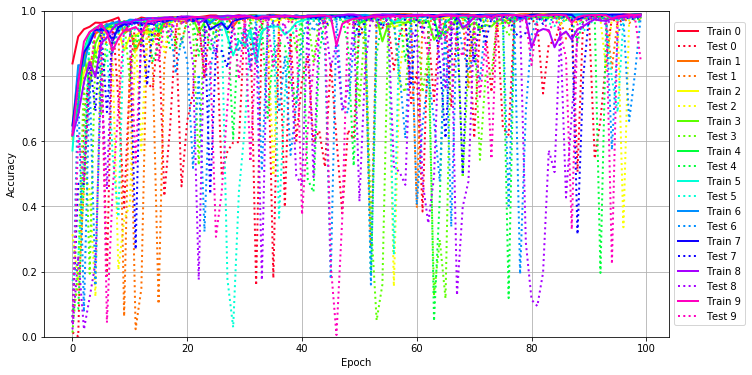

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

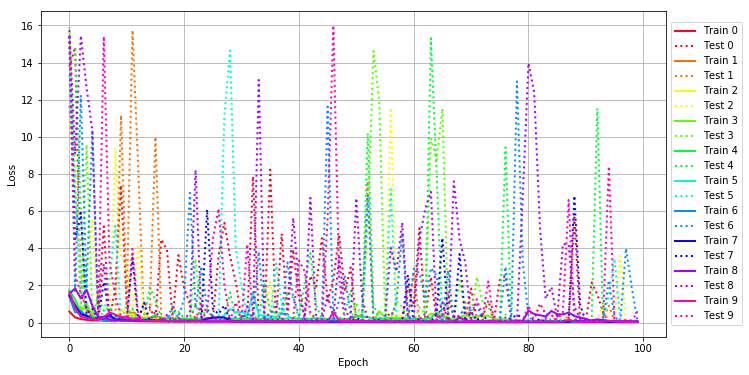

In [12]:
plot_loss(history)

Plotting the confusion matrix


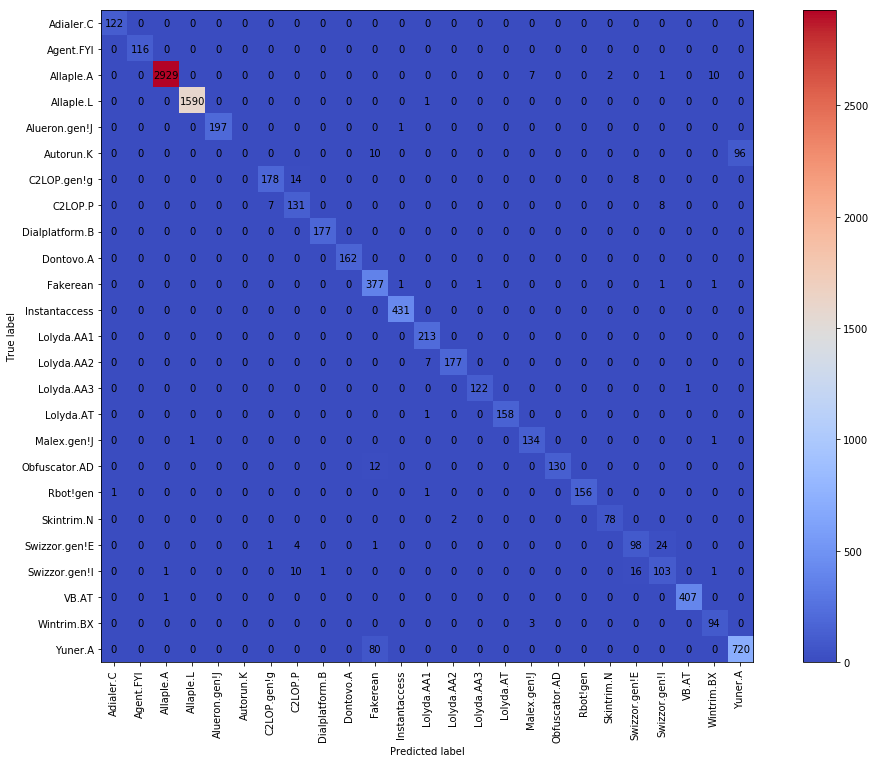

In [13]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(18, 12)
plt.imshow(conf_mat,interpolation='nearest',cmap='coolwarm')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


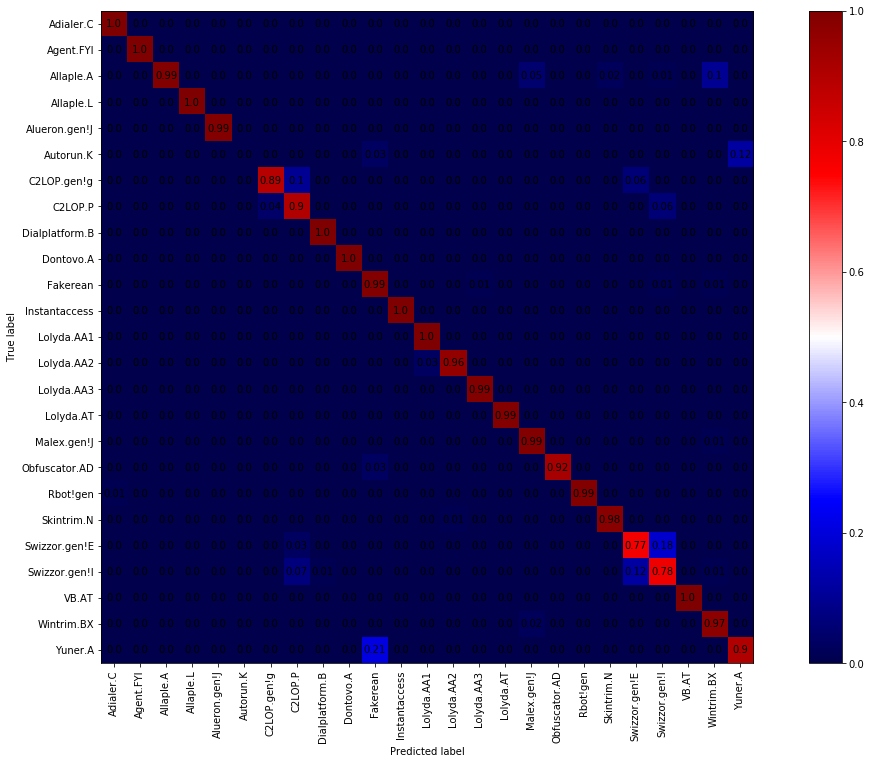

In [14]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='seismic')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


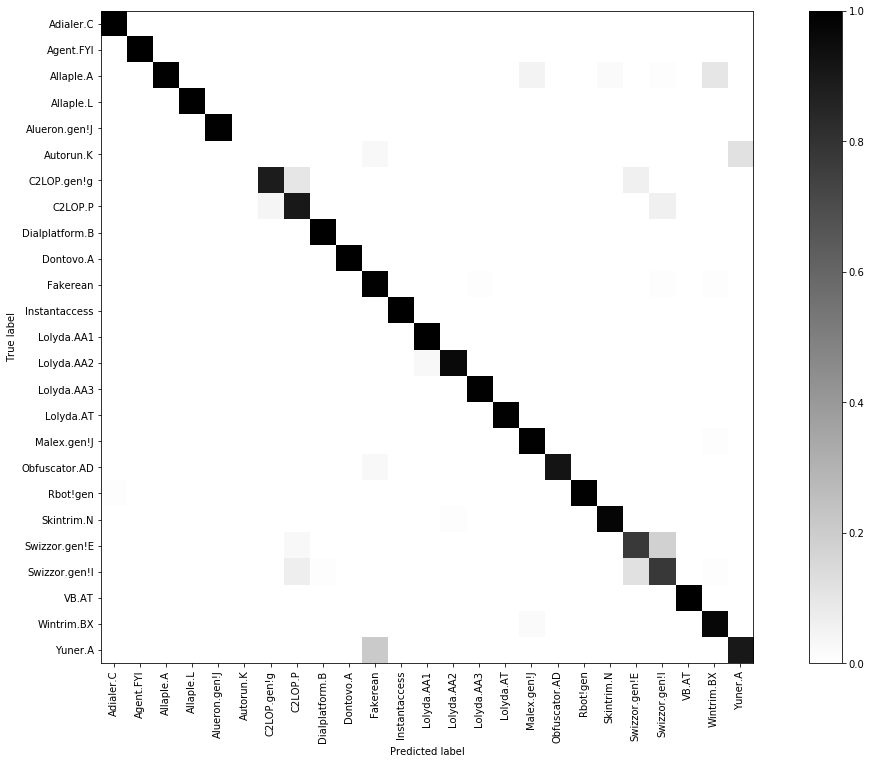

In [15]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='binary')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


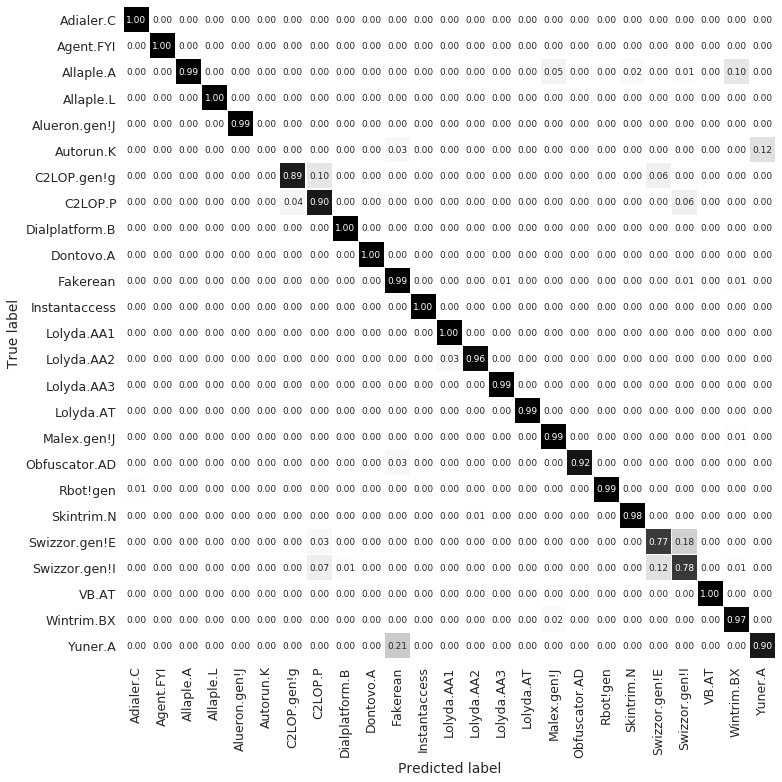

In [16]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [44]:
for h in history:
    print(h.history)

{'acc': [0.83809864190126393, 0.92077674528005604, 0.94305456279714195, 0.95067905649730977, 0.96330712410788433, 0.962354062425542, 0.9664045747104133, 0.97212294496068619, 0.97903264237779475, 0.93423874194434009, 0.96199666429821407, 0.97033595422463448, 0.97891350964974977, 0.97581605906142266, 0.97557779366213959, 0.97796044791060055, 0.96914462711460569, 0.97962830593280914, 0.97974743861824887, 0.98165356212495081, 0.9717655468191565, 0.98093876575668115, 0.98034310218746501, 0.98236835835120329, 0.98522754345503705, 0.98522754348344055, 0.9798665713320921, 0.97545866094829636, 0.98308315463426255, 0.98606147248034315, 0.98189182749583037, 0.98558494162497023, 0.98594233973809642, 0.97736478436978791, 0.98677626876340241, 0.98725279959037182, 0.98522754348344055, 0.98129616392661423, 0.98153442935430069, 0.98534667619728378, 0.98260662377888963, 0.98260662377888963, 0.98248749103664301, 0.98070050035739809, 0.98498927806995584, 0.98070050035739809, 0.98248749103664301, 0.9846318

In [104]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

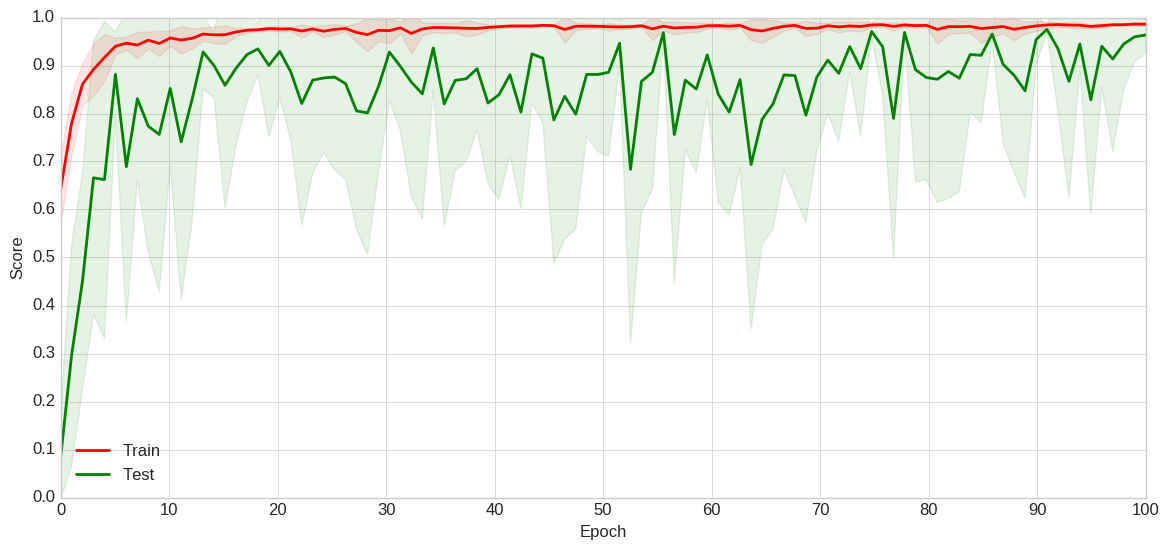

In [105]:
plot_mean_acc(history)

In [114]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

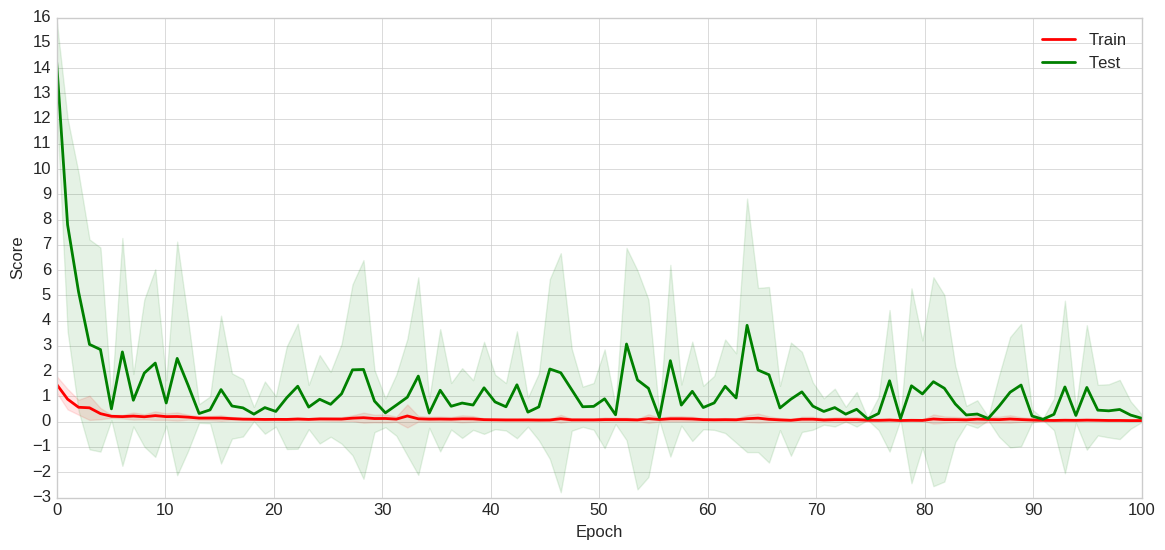

In [115]:
plot_mean_loss(history)

In [1]:
history = [{'acc': [0.83809864190126393, 0.92077674528005604, 0.94305456279714195, 0.95067905649730977, 0.96330712410788433, 0.962354062425542, 0.9664045747104133, 0.97212294496068619, 0.97903264237779475, 0.93423874194434009, 0.96199666429821407, 0.97033595422463448, 0.97891350964974977, 0.97581605906142266, 0.97557779366213959, 0.97796044791060055, 0.96914462711460569, 0.97962830593280914, 0.97974743861824887, 0.98165356212495081, 0.9717655468191565, 0.98093876575668115, 0.98034310218746501, 0.98236835835120329, 0.98522754345503705, 0.98522754348344055, 0.9798665713320921, 0.97545866094829636, 0.98308315463426255, 0.98606147248034315, 0.98189182749583037, 0.98558494162497023, 0.98594233973809642, 0.97736478436978791, 0.98677626876340241, 0.98725279959037182, 0.98522754348344055, 0.98129616392661423, 0.98153442935430069, 0.98534667619728378, 0.98260662377888963, 0.98260662377888963, 0.98248749103664301, 0.98070050035739809, 0.98498927806995584, 0.98070050035739809, 0.98248749103664301, 0.98463187988582102, 0.97653085534448192, 0.98189182746742687, 0.98487014535611261, 0.98236835832279978, 0.98641887062187272, 0.98725279961877532, 0.98665713602115579, 0.98487014534191086, 0.98796759590183469, 0.98784846315958796, 0.98832499401496088, 0.98618060519418638, 0.98665713604955918, 0.98772933044574474, 0.98177269481039053, 0.9725994757876556, 0.98320228734810577, 0.98558494159656673, 0.98546580891112701, 0.98582320705265669, 0.98832499404336427, 0.98844412672880411, 0.98451274717197779, 0.98487014534191086, 0.98772933047414824, 0.98832499401496088, 0.98761019776030501, 0.98475101268487453, 0.97200381224684296, 0.98510841074119393, 0.98784846318799147, 0.98820586132952104, 0.98689540147724564, 0.98689540147724564, 0.9798665713604956, 0.98618060519418638, 0.9876101978171119, 0.97784131522516082, 0.98701453416268548, 0.98796759595864159, 0.9822492256515617, 0.98641887062187272, 0.98725279961877532, 0.97939004047671929, 0.9820109601812701, 0.98701453419108887, 0.9865380033499177, 0.98367881820347869, 0.98820586132952104, 0.98832499404336427, 0.98856325947105073, 0.98832499404336427], 'val_loss': [13.778979936226335, 14.82392674198857, 1.5691594275217207, 0.8642174691922726, 0.23041570099893852, 0.54387781392245815, 5.1802026110351402, 0.093031533652788434, 1.908944701708523, 7.3911416237947671, 0.85903002534594142, 0.092965853245802685, 0.21972844282179568, 1.0295948362855054, 0.82311302894755967, 0.18594032167457045, 4.4789585850226183, 3.9372852553214344, 0.20595232501056873, 3.6305729110188114, 1.8728181144244791, 1.0024559091875163, 0.15662746013846821, 0.70978284569718342, 0.10165062853341206, 0.10866027740594097, 3.60683456369178, 5.3784081676051425, 3.5662002935645645, 2.1788620238626013, 0.17689213225680833, 0.1086338162832627, 7.8704645161906246, 0.18572978012746683, 0.18043844945495949, 8.2411997709324751, 0.13475453244798644, 4.7911885549151707, 0.30045359464654148, 3.9312485410107536, 1.2910712661867143, 0.38549356116820022, 2.5197942108073561, 1.9402884014542141, 4.5476057685872231, 1.1798837436435976, 2.3067130667743858, 4.7331766211797319, 1.6739413031588786, 2.973285300138766, 0.085884564895387344, 0.10265032598376844, 0.093619845211578262, 0.11391678557454475, 0.26867658478228212, 0.15847075230900257, 0.5733237115577573, 0.32538874418272701, 0.10544175697398488, 1.9504701616429778, 0.94602070636850188, 5.084048925127302, 0.28808358188265309, 2.4530785370440711, 0.11928001632868714, 0.10249139880177117, 1.6014856669007156, 0.18716324161016412, 0.09838463875160236, 0.098421312872799011, 1.8426187457201422, 0.18087887227851002, 0.29519261150687787, 1.1873476761358757, 0.093901928591810041, 2.2902623892066969, 2.5129589503404324, 0.087912492862537314, 0.11113633114882326, 0.091619835827233542, 0.13077884872510323, 0.17336648457283868, 1.0248460056605162, 0.45083892104959994, 0.4091836824632501, 0.1410160274042504, 0.090071581598791958, 0.090355226920205284, 5.6673216491464586, 0.094770262641068456, 0.099440225762519596, 2.1630518037806112, 1.5073963260682171, 0.54793140277976082, 0.083380263499065896, 0.19746921268247422, 0.094402121721483392, 0.094624921029470802, 0.087385520474437345, 0.083341614098753777], 'val_acc': [0.013756613756613757, 0.0010582010582010583, 0.68253968253968256, 0.80529100529100528, 0.86878306878306877, 0.9015873015873016, 0.1873015873015873, 0.97354497354497349, 0.72592592592592597, 0.39576719576719577, 0.79682539682539677, 0.97460317460317458, 0.93862433862433858, 0.77777777777777779, 0.76190476190476186, 0.95238095238095233, 0.43174603174603177, 0.64021164021164023, 0.94708994708994709, 0.46137566137566138, 0.66243386243386249, 0.74708994708994714, 0.96931216931216935, 0.79153439153439153, 0.97248677248677251, 0.97354497354497349, 0.49417989417989416, 0.56825396825396823, 0.59576719576719572, 0.59682539682539681, 0.96507936507936509, 0.97566137566137567, 0.15767195767195769, 0.95978835978835975, 0.95449735449735451, 0.17989417989417988, 0.96931216931216935, 0.39788359788359789, 0.93333333333333335, 0.60105820105820107, 0.78835978835978837, 0.85925925925925928, 0.59576719576719572, 0.63174603174603172, 0.52063492063492067, 0.84126984126984128, 0.60846560846560849, 0.37883597883597886, 0.6338624338624339, 0.6063492063492063, 0.97777777777777775, 0.96825396825396826, 0.97566137566137567, 0.97248677248677251, 0.94708994708994709, 0.96084656084656084, 0.81904761904761902, 0.92169312169312168, 0.97566137566137567, 0.71640211640211637, 0.81058201058201063, 0.38412698412698415, 0.94179894179894175, 0.7227513227513227, 0.96931216931216935, 0.97883597883597884, 0.70793650793650797, 0.946031746031746, 0.97142857142857142, 0.97671957671957677, 0.60952380952380958, 0.95026455026455026, 0.93968253968253967, 0.7502645502645503, 0.97777777777777775, 0.64021164021164023, 0.61904761904761907, 0.97883597883597884, 0.97460317460317458, 0.97671957671957677, 0.97354497354497349, 0.95661375661375658, 0.74603174603174605, 0.89841269841269844, 0.90476190476190477, 0.95873015873015877, 0.97777777777777775, 0.97671957671957677, 0.50582010582010584, 0.97777777777777775, 0.97777777777777775, 0.54603174603174598, 0.66455026455026456, 0.85396825396825393, 0.97883597883597884, 0.95661375661375658, 0.97777777777777775, 0.97883597883597884, 0.97989417989417993, 0.97989417989417993], 'loss': [0.59466834752253472, 0.28216909771451842, 0.19218253446017272, 0.15193107906681941, 0.11325772130257861, 0.11918674384003911, 0.10087088596857756, 0.085613470090065424, 0.069522979983707989, 0.22912279005018849, 0.12123126346837176, 0.091377284744395396, 0.068980490919739568, 0.071811589295448841, 0.077187399123612263, 0.065015033704058062, 0.10540754106565901, 0.066105012468370569, 0.061746526760716423, 0.05530721547686971, 0.090883085401655517, 0.061070098938659625, 0.05931182893750666, 0.055859251477402116, 0.047242529143499197, 0.046903912162185001, 0.066604072266685022, 0.083922608863151379, 0.055460203505124053, 0.043147497010466766, 0.059154385421891095, 0.045303890314720943, 0.045166355548641755, 0.069319802843357578, 0.043052531141288042, 0.041481611833476949, 0.047157564109037299, 0.065957374245901174, 0.063887305008742332, 0.047193190777460849, 0.056843937537749384, 0.054948007956871485, 0.058455039019886586, 0.062355566618057384, 0.047889863990987512, 0.063236345765787794, 0.057298088559429507, 0.051206452181318245, 0.082824354404164177, 0.05580419411339986, 0.046725802822981617, 0.054913127968389132, 0.044254549067802081, 0.040660992908707144, 0.042006536079129068, 0.049320349537682925, 0.037533973460057955, 0.038910512621821831, 0.036654926733971922, 0.045553816772228709, 0.042076948664910262, 0.039371338463238599, 0.06176004900175644, 0.10333321075944182, 0.054362224758226996, 0.045027786144649015, 0.046421334151891348, 0.045986906564806689, 0.037578318075005966, 0.037374721569747395, 0.050108251892152726, 0.04975647076410511, 0.039153362430526237, 0.037508986749186353, 0.0396312824029929, 0.053012739860758717, 0.11969292227046559, 0.048264749487518042, 0.039667681907830647, 0.037276991179458353, 0.040982625776294274, 0.040733925406509303, 0.069660515547968579, 0.044377331035457997, 0.040895212689325416, 0.068407918275297325, 0.040070696671093704, 0.038562678810753141, 0.056193768415375496, 0.041841547684120454, 0.040699530118614373, 0.06969525535276512, 0.057587313423390782, 0.040152394468191549, 0.041322307025204674, 0.05326354105339743, 0.038042228913907926, 0.036857837683296868, 0.035903683510312291, 0.036281081334143442]}, 
{'acc': [0.62022150778069129, 0.73240443018201962, 0.85089913074127244, 0.91508872226915206, 0.92806954874770331, 0.94807669415677798, 0.9586757176246361, 0.94533762067815474, 0.96284387292529172, 0.93021317148430083, 0.94212218649517687, 0.87697987387801291, 0.91401691090795156, 0.94533762067815474, 0.92973681087932292, 0.92223413133672327, 0.9591520782225158, 0.96748838880963017, 0.97153745395194291, 0.96594021685764853, 0.96772656901274268, 0.97534833869239013, 0.97677742050732408, 0.97642015005359062, 0.98058830544652431, 0.98070739549839225, 0.97773014181665652, 0.97987376446452501, 0.95081576763540132, 0.97487197808741222, 0.97975467428843632, 0.97939740383470286, 0.97761105166541207, 0.97987376443968088, 0.98463737048946054, 0.98356555912826005, 0.98332737892514765, 0.98273192816892518, 0.97284744562273073, 0.98046921519590335, 0.98368464927950461, 0.98380373943074906, 0.98594736215314993, 0.98713826376497138, 0.9818982970108372, 0.98666190306061685, 0.98690008336310586, 0.98463737048946054, 0.98630463270626001, 0.97558651909425564, 0.98428010014220191, 0.97487197808741222, 0.97725378121877693, 0.98070739549839225, 0.98678099321186141, 0.98594736215314993, 0.986066452403771, 0.98832916517803981, 0.98832916517803981, 0.98868643573114978, 0.9834464689770156, 0.98439919028634815, 0.98523282124568301, 0.984994640943194, 0.9790401333809694, 0.98451828033821598, 0.98428010003572708, 0.98761462427057278, 0.98821007502679525, 0.97522924854114568, 0.98642372286460278, 0.98535191139692746, 0.98642372286460278, 0.98416100998385914, 0.98547100165464685, 0.98154102665648024, 0.98678099331833624, 0.98630463260688339, 0.98797189472430635, 0.98856734557990533, 0.98868643563177327, 0.98844825542866088, 0.98868643563177327, 0.98856734557990533, 0.98844825532928426, 0.9880909848755508, 0.98666190306061685, 0.97832559247350248, 0.98297010837203769, 0.98844825532928426, 0.98773371452119385, 0.98832916517803981, 0.98856734548052871, 0.98701917361372693, 0.97856377277599138, 0.98499464104257062, 0.98559009179879298, 0.98642372285750446, 0.98642372275812795, 0.98797189482368286], 'val_loss': [11.656209945678711, 6.9266230525990711, 2.9905522467287735, 0.84893068152375029, 0.26303196046699129, 0.19553084128917908, 0.28778674863953629, 0.33944142598761623, 0.092933213686266017, 11.164119793351288, 1.0955243736466951, 15.741664246642159, 8.3363015241683662, 0.18381342549675841, 0.65340474633907308, 9.9918306516740483, 0.45756106407652486, 0.093602206619803868, 0.08622232655306919, 0.27240388042386421, 0.067812133498580132, 0.069871192709872784, 0.076506634646069008, 0.082709608882170493, 0.063099271554184475, 0.084906445597571559, 0.097147354142564382, 0.35098247876865496, 0.21403714179043759, 0.075838974960382152, 0.094166809868468856, 0.062645522710244317, 0.074033352250415144, 0.077993954382384267, 0.087249023262723172, 0.1011089469395703, 0.069865952199469214, 0.080803788490874467, 0.098505236038144192, 0.073656449686475486, 0.080239035213038074, 0.086828564657514248, 0.086527228214907201, 0.091724845882753314, 0.1078485209374212, 0.086160080721304627, 0.11316873959654844, 0.10345009474866665, 0.13209470532590578, 0.24222298744757656, 0.15873743995128292, 0.2999956844149122, 7.613753288414828, 0.12059623962406646, 0.10125311416813465, 0.2172107653966843, 0.091475862099132568, 0.14717579431617525, 0.1010545716087172, 0.10377288008581603, 2.7355322395540345, 0.10074720250379013, 0.17807309194458268, 0.11207528294458041, 0.09814467860461204, 0.3659859825460301, 0.10245191972026194, 0.088764846032868577, 0.090070628976318873, 1.0937019053277126, 0.087035505622114137, 0.087762394373755923, 0.18409977399846914, 0.10553428898430341, 0.11570433079520381, 0.13990572410996638, 0.10301615745139063, 0.1199266454473884, 0.084673882127627748, 0.081997738719710736, 0.079669200353789368, 0.083636506118125328, 0.089241435903600397, 0.088223659235246346, 0.083339700000201383, 0.10613108727390282, 0.52830620674640472, 0.15695606505700982, 0.1204982877589343, 0.099706125442870761, 0.094350656811734254, 0.13930346433032437, 0.092009710389508545, 0.1369154638760845, 0.91037882543247706, 0.093371009523832024, 0.090578017096408892, 0.17573305953397633, 0.084617508501207042, 0.11381364521058784], 'val_acc': [0.078556263269639062, 0.15498938428874734, 0.45435244161358812, 0.8152866242038217, 0.93099787685774948, 0.93736730360934184, 0.89808917197452232, 0.90339702760084928, 0.96815286624203822, 0.062632696390658174, 0.85350318471337583, 0.023354564755838639, 0.14755838641188959, 0.9575371549893843, 0.82271762208067944, 0.10084925690021232, 0.84076433121019112, 0.96815286624203822, 0.97346072186836519, 0.90552016985138006, 0.97346072186836519, 0.97770700636942676, 0.97239915074309979, 0.97346072186836519, 0.97558386411889597, 0.97664543524416136, 0.97239915074309979, 0.92569002123142252, 0.95329087048832273, 0.97558386411889597, 0.96921443736730362, 0.97770700636942676, 0.97346072186836519, 0.97452229299363058, 0.97346072186836519, 0.96709129511677283, 0.97770700636942676, 0.97876857749469215, 0.9713375796178344, 0.97558386411889597, 0.97770700636942676, 0.97346072186836519, 0.96815286624203822, 0.9713375796178344, 0.97558386411889597, 0.97664543524416136, 0.97346072186836519, 0.9713375796178344, 0.96072186836518048, 0.95435244161358812, 0.96284501061571126, 0.89490445859872614, 0.27494692144373672, 0.96815286624203822, 0.97346072186836519, 0.9437367303609342, 0.97452229299363058, 0.97027600849256901, 0.97664543524416136, 0.97558386411889597, 0.39490445859872614, 0.97239915074309979, 0.96496815286624205, 0.97239915074309979, 0.97664543524416136, 0.94798301486199577, 0.97452229299363058, 0.98089171974522293, 0.97664543524416136, 0.76539278131634825, 0.97770700636942676, 0.97664543524416136, 0.96496815286624205, 0.97452229299363058, 0.96709129511677283, 0.96496815286624205, 0.97346072186836519, 0.97239915074309979, 0.98089171974522293, 0.98089171974522293, 0.97876857749469215, 0.98089171974522293, 0.97983014861995754, 0.97876857749469215, 0.97983014861995754, 0.97346072186836519, 0.9140127388535032, 0.95859872611464969, 0.96709129511677283, 0.97452229299363058, 0.97664543524416136, 0.96921443736730362, 0.97664543524416136, 0.9713375796178344, 0.82377919320594484, 0.97027600849256901, 0.97770700636942676, 0.96178343949044587, 0.97346072186836519, 0.97027600849256901], 'loss': [1.4084055014092169, 0.84438057763244023, 0.45790975368830711, 0.29370463330276925, 0.25411105516539795, 0.18332590116171293, 0.13515904473735987, 0.18909911018291287, 0.13627359877601469, 0.28234680321893196, 0.28517748765506334, 0.60128218606353956, 0.35682872474740146, 0.22932999279153507, 0.29906901118442164, 0.27741866690020511, 0.12470639190660199, 0.099749691535053156, 0.084371101093871456, 0.10623718795143765, 0.098846651636338226, 0.075546386996074508, 0.068595983297417132, 0.069760444466806779, 0.060345319008222431, 0.062282322490816527, 0.063776613763574908, 0.06934161314059116, 0.15355654048595993, 0.079252926776059412, 0.063371092550003116, 0.064086500034880839, 0.069508749913130122, 0.063656987752590183, 0.049324282295172293, 0.05121672046598727, 0.049209322514627125, 0.051872382351965139, 0.087287028367936476, 0.060430964737388793, 0.048672783941498994, 0.048651728226628117, 0.044444571422319605, 0.041518290818085397, 0.056105186309294112, 0.0430182067499255, 0.042430534359030853, 0.048039777876960746, 0.042706416695121076, 0.080353480961488311, 0.047725542639783125, 0.076613424387775436, 0.072064150571539184, 0.060313627699351675, 0.044301111227380771, 0.043024827050402489, 0.041616009635926432, 0.038132055220424302, 0.037601690916407741, 0.036510269062759282, 0.052585194716304344, 0.049834390474214743, 0.044994093826431256, 0.04790870264985312, 0.072631912986281313, 0.048262290389048453, 0.050342311833763219, 0.038697145825365729, 0.037879369672038692, 0.088893117216006776, 0.043503626772899408, 0.046336119675761935, 0.045412588959061362, 0.051123595542427583, 0.047147633027601658, 0.056725890120466763, 0.042638671558585015, 0.042677601048831781, 0.038056592919108567, 0.035988281648333217, 0.035922194819871238, 0.036492489996134733, 0.035846175908078759, 0.036566594830081192, 0.037067858463006177, 0.037643281465014305, 0.042694411888573092, 0.069057728025147896, 0.050977949717785846, 0.037455669020515434, 0.039201189075195465, 0.036547582782760601, 0.036907496649427107, 0.040816566236632143, 0.073105463184921157, 0.047250663324155964, 0.043283970748595968, 0.043597298790631414, 0.041914087349438689, 0.037092790941021136]}, 
{'acc': [0.60588025237929044, 0.7411022497605545, 0.81026068330165846, 0.8490655874726375, 0.85954053091046467, 0.92024758970037901, 0.94250684443747279, 0.94488751341254773, 0.94119747649798891, 0.87751458161161877, 0.92072372349397491, 0.92358052613493691, 0.93655517203880767, 0.93429353649794178, 0.93036543270786976, 0.96083799548382387, 0.95095821938732095, 0.96274253065111293, 0.96857516975037306, 0.974645875491013, 0.97631234377569387, 0.978931079633377, 0.97738364480418993, 0.97643137723828277, 0.97155100583263898, 0.97833591241266682, 0.97857397928818002, 0.98035948101416504, 0.98071658135936202, 0.98131174861554682, 0.97928818010628305, 0.98297821687894293, 0.98274014998214498, 0.98202594929175102, 0.98333531722414003, 0.96690870137345775, 0.97226520652303294, 0.98214498274014994, 0.98333531722414003, 0.98214498286785901, 0.98464468528423799, 0.98345435067253895, 0.98452565183583907, 0.98226401631625804, 0.98464468528423799, 0.98369241756933701, 0.98393048446613496, 0.98440661825973097, 0.98404951791453399, 0.98500178550172601, 0.98678728723480591, 0.98488275205332698, 0.98654922034510284, 0.97833591251909102, 0.98166884895364892, 0.98285918343054401, 0.94929175110973496, 0.95571955720976187, 0.95893346030234494, 0.97940721342697301, 0.98333531722414003, 0.98523985239852396, 0.98595405308891804, 0.98571598619211998, 0.9825020830995369, 0.97988334723475889, 0.98226401618854897, 0.98369241756933701, 0.98250208308534703, 0.98631115356182397, 0.98726342102130704, 0.98607308666502602, 0.98595405321662699, 0.98523985239852396, 0.98702535412450898, 0.98726342102130704, 0.98714438757290801, 0.98702535412450898, 0.98702535412450898, 0.98654922033091297, 0.98726342102130704, 0.98738245446970596, 0.98845375550529702, 0.98714438757290801, 0.98750148791810499, 0.98238304976465707, 0.98595405308891804, 0.986668253779312, 0.98643018688251394, 0.98750148791810499, 0.98857278895369594, 0.98857278895369594, 0.98833472205689799, 0.98523985239852396, 0.97833591239138196, 0.98440661825973097, 0.98131174860135695, 0.98452565170813, 0.98738245446970596, 0.98833472205689799], 'val_loss': [11.048971611299498, 9.1192484857685283, 2.2760456844941892, 2.9965040830533898, 5.4736362184797018, 0.21394647768279637, 0.14903978265321521, 0.3614243318213583, 9.4039246024353425, 3.5240523029746278, 3.2174985926352075, 0.21267862729172207, 4.2171766447868428, 0.16299453689091242, 0.31646031910168432, 0.10882376387282443, 0.38621271523966716, 0.12302956020018693, 0.12241003031620006, 0.098688046943380445, 0.083559189414566276, 0.12516336112249909, 0.09681250178684872, 0.11469364802152088, 0.13222575041915732, 0.14189754158575169, 0.086772581373628324, 0.098448928984960341, 0.091039183531276713, 0.10185007319885191, 0.10202976636349537, 0.093188404475793254, 0.18092296568990579, 0.096252143031053616, 0.15079801869741866, 2.3164458680254563, 0.11097873043036088, 0.10122402368898023, 0.10548237350198962, 0.10631781045227934, 0.10359960010877474, 0.11273620052824646, 0.10609144772542753, 0.093189620970792295, 0.11874110831353379, 0.24005157800467272, 0.090792961270910466, 0.11495436304412694, 0.094516235413059729, 0.11092987864378538, 0.096518384786152683, 0.1805248144759746, 0.10953012126792562, 0.25521098160440153, 0.152290035840876, 0.11279270324611794, 11.569843105161622, 0.68636768511426982, 0.20128331148426601, 0.075748617227415521, 0.093233983871886444, 0.085784251506442574, 0.090384809027870036, 0.097925426900916268, 0.12104935205610991, 0.081816465288074805, 0.08610458897312985, 0.13245870283019712, 0.1013359836265961, 0.083123997816570261, 0.088116377617219091, 0.089242773929743405, 0.28419765839724254, 0.098421855253288587, 0.19313698154587608, 0.093714375107413136, 0.1371787398328142, 0.11640109407494444, 0.088023771489724137, 0.10870667981550017, 0.11131006759591001, 0.092501163390090513, 0.091864232056515727, 0.090109022802455571, 0.10205411288505445, 0.13797648197726928, 0.12299260509352762, 0.13146833640553413, 0.19375848890888367, 0.097085419278271745, 0.097122977681488545, 0.094658815301556232, 0.10859310092875218, 1.0291618080157241, 0.11529360870488295, 0.17690033658788895, 3.5903526847042255, 0.097683500949306168, 0.090258157702849756, 0.097865772671582488], 'val_acc': [0.31449893390191896, 0.17057569296375266, 0.5074626865671642, 0.44882729211087419, 0.12366737739872068, 0.94456289978678043, 0.94776119402985071, 0.84328358208955223, 0.20575692963752665, 0.35820895522388058, 0.40511727078891258, 0.92430703624733479, 0.5714285714285714, 0.95309168443496806, 0.89339019189765456, 0.96908315565031988, 0.87313432835820892, 0.9733475479744137, 0.96481876332622596, 0.9733475479744137, 0.97761194029850751, 0.96375266524520253, 0.97547974413646055, 0.9733475479744137, 0.96162046908315568, 0.95842217484008529, 0.97654584221748397, 0.97654584221748397, 0.97654584221748397, 0.96908315565031988, 0.96695095948827292, 0.97867803837953093, 0.96268656716417911, 0.97761194029850751, 0.96481876332622596, 0.49466950959488271, 0.96908315565031988, 0.97547974413646055, 0.97121535181236673, 0.97228144989339016, 0.97121535181236673, 0.97441364605543712, 0.97654584221748397, 0.97228144989339016, 0.9658848614072495, 0.96055437100213215, 0.97974413646055436, 0.97974413646055436, 0.97547974413646055, 0.97228144989339016, 0.97761194029850751, 0.95202558635394452, 0.97547974413646055, 0.94776119402985071, 0.96481876332622596, 0.97441364605543712, 0.15458422174840086, 0.80277185501066095, 0.96162046908315568, 0.97761194029850751, 0.97547974413646055, 0.97867803837953093, 0.97867803837953093, 0.97867803837953093, 0.97121535181236673, 0.97974413646055436, 0.97867803837953093, 0.9733475479744137, 0.97121535181236673, 0.97867803837953093, 0.97654584221748397, 0.97867803837953093, 0.96695095948827292, 0.97974413646055436, 0.93923240938166308, 0.97867803837953093, 0.97121535181236673, 0.97014925373134331, 0.97761194029850751, 0.97228144989339016, 0.97654584221748397, 0.97867803837953093, 0.97867803837953093, 0.97761194029850751, 0.97547974413646055, 0.95842217484008529, 0.97228144989339016, 0.96908315565031988, 0.96268656716417911, 0.97974413646055436, 0.97441364605543712, 0.97547974413646055, 0.97441364605543712, 0.81769722814498935, 0.97761194029850751, 0.96375266524520253, 0.33582089552238809, 0.97547974413646055, 0.97654584221748397, 0.97547974413646055], 'loss': [1.7525034293633475, 1.0100414010686911, 0.8186567465104797, 0.64528330695471614, 0.48362341685999494, 0.2468582271869772, 0.18156013357796821, 0.16864595670328866, 0.23134024376500831, 0.69896882473038935, 0.50500452708607702, 0.41344135994180981, 0.3395598766676316, 0.28179147825001566, 0.26508866464959741, 0.14805023315591112, 0.23752295572890256, 0.13357655343376459, 0.10490217751430594, 0.079278436322561152, 0.074019754550035843, 0.066054213282912388, 0.066385547001366674, 0.07100245754231499, 0.090434291024315772, 0.068982301060180842, 0.064826925931798396, 0.058525936891565489, 0.063479327103181826, 0.059662186701075544, 0.062998807341757876, 0.05251762265949881, 0.053979260961932771, 0.054643957192891272, 0.051187177831563138, 0.11979428185208782, 0.089598002787131786, 0.055305295636587634, 0.05083643102329085, 0.058194603139964503, 0.049245164741073218, 0.050677491270591922, 0.048550180564918853, 0.053664049996802986, 0.046587553601182087, 0.054138045986377545, 0.051431282790710978, 0.048899646761804222, 0.049090435100749709, 0.048003292884870541, 0.043703260409052973, 0.048523492294549588, 0.044755557362855351, 0.08140860881677249, 0.05832421126365378, 0.056475426894847074, 0.32421035963699174, 0.34371322830820805, 0.29862411278304973, 0.070726429519660697, 0.051881441463141081, 0.046928053277242809, 0.043011705211518161, 0.045240134743807545, 0.053612780388643762, 0.069120552781479314, 0.056945630296782755, 0.055965081872741122, 0.056738495160184234, 0.043103816264187376, 0.041792063493050577, 0.045082754201086456, 0.045878061526957725, 0.046588061041061314, 0.041525003377673224, 0.041154030477655826, 0.04125868351574654, 0.041814637305333621, 0.040528868781680959, 0.041626390011411538, 0.040605058645903393, 0.03854628705856715, 0.036937517174401531, 0.041373472694397805, 0.039356628957341655, 0.051328475328658738, 0.046184766719244361, 0.043839282264522592, 0.042687356054743844, 0.040613762725270119, 0.036194242988437604, 0.036549328651100506, 0.036450101500934674, 0.052515731573702609, 0.06989299467747169, 0.052458332061485362, 0.067838053066811593, 0.046611827360961658, 0.039246016405719668, 0.037078549519825116]}, 
{'acc': [0.6501249554014541, 0.80733071523494104, 0.86921337615389571, 0.76187076042141921, 0.89932167083184578, 0.93502320599785793, 0.94668570748542191, 0.95918124489283174, 0.96287040352665298, 0.96667856717838863, 0.96929667975722955, 0.9667975722956087, 0.95894323457327257, 0.97405688454533679, 0.97453290491491129, 0.97869808406726555, 0.97857907895004548, 0.97774604312950519, 0.97846007383282552, 0.97691300730896491, 0.97727002266062513, 0.97786504822544551, 0.93323812923955729, 0.96429846483398785, 0.96822563378027504, 0.9556110912769249, 0.97500892543344431, 0.97572295618641736, 0.98024515064077888, 0.98048316082556619, 0.98119719147923357, 0.98286326312031413, 0.98369629894085442, 0.98095918124479353, 0.98203022729977385, 0.9845293347613947, 0.98441032964417474, 0.98345828870641439, 0.98476734499583485, 0.97857907890039275, 0.98143520171367371, 0.98441032964417474, 0.98179221706533382, 0.98357729382363446, 0.98548137569915506, 0.98250624776865403, 0.9841723194097346, 0.98571938598324793, 0.98679043203822836, 0.98369629899050726, 0.98595739616803524, 0.98512436039714779, 0.97227180768773058, 0.97834106876525828, 0.90562894214381351, 0.95656313231399082, 0.96275139840943291, 0.96465548018564795, 0.96287040344153385, 0.96679757239491437, 0.97286683332348356, 0.96025229086269304, 0.96905866957244224, 0.91062715701740238, 0.93502320604751066, 0.92907295023616154, 0.95787218860341128, 0.97096275132737753, 0.94490063075549424, 0.95144591227352915, 0.96429846484817439, 0.94775675359005507, 0.95608711175999161, 0.95156491730563009, 0.96858264905390934, 0.97346185885993097, 0.96001428066371919, 0.97703201247583782, 0.97691300725931218, 0.97893609425205286, 0.98084017622687913, 0.97905509936927293, 0.97965012495537307, 0.98084017622687913, 0.98155420683089378, 0.98381530405807449, 0.98119719147923357, 0.98381530405807449, 0.98441032969382747, 0.98203022729977385, 0.98607640128525531, 0.98536237058193499, 0.98405331429251452, 0.98548137569915506, 0.98357729387328718, 0.98405331434216736, 0.98429132452695467, 0.98369629899050726, 0.98536237056065523, 0.9779840533142925], 'val_loss': [15.911453181861813, 7.3991214576949424, 0.78221508119908023, 9.5723261828096504, 0.44420342182374406, 1.1644336484436295, 0.14402623742054671, 0.14356336092554495, 0.12107174822754171, 0.11512362320198972, 0.97886086000591266, 0.2497785185611982, 0.41083950831944871, 0.077471875664220854, 0.23589214314826024, 0.088606047137584701, 0.073992220302804917, 0.068801922236099586, 0.74127287458246338, 0.090029220120235023, 0.11279689722782017, 0.14360610993448933, 3.4333013746027765, 0.093546276336981579, 0.13023708393632108, 0.25002063348074444, 0.083784708749248177, 0.064844168887800008, 0.05753037985215266, 0.074505580011078626, 0.056391215257587418, 0.08286834903202929, 0.075821649592554372, 0.1346746676115908, 0.058816214230132453, 0.064179352150135968, 0.06045192151664857, 0.067903535316375371, 0.053094657288701823, 0.39155302145796961, 0.071048580751414556, 0.061219331016366042, 0.50336844169108885, 0.059849604174224101, 0.1698148038644248, 0.20506965392468196, 0.073549738813004598, 0.11837509057684065, 0.095252717209669394, 0.078868840281018524, 1.1017480415479144, 0.093163961156581834, 5.4875164369487353, 14.626806731916901, 11.853379070249378, 0.51832580968437114, 0.19990815894089192, 1.1606864170927522, 0.85885934429800403, 0.13041428860444099, 0.073904050064764956, 0.82609283682118118, 0.46743796676652044, 9.9272310794928131, 8.7723540414092884, 11.528416576548519, 0.26197955909935217, 0.15281363335461953, 2.2806009784436378, 0.556150503237692, 0.44387434344961602, 2.4590402732356491, 1.1046066926075861, 0.85387187630224681, 0.13638147602925418, 0.1309267120101513, 0.45304798337822066, 0.1279263233598848, 0.068615103335114946, 0.058253742087764786, 0.055684676869547818, 0.061295791954394267, 0.083314381718710293, 0.059870667918750231, 0.061359865367920138, 0.061017585510706955, 0.24525148338041727, 0.062553488629974813, 0.056940369252364086, 0.05853748982851676, 0.11380815117344642, 0.056687990743588067, 0.078307475032422511, 0.14197312558110103, 0.06727933105078894, 0.066279344300990209, 0.072305748372999121, 0.056454791873404096, 0.062672524691991457, 0.057995894454996651], 'val_acc': [0.01282051282051282, 0.21581196581196582, 0.79380341880341876, 0.19337606837606838, 0.87606837606837606, 0.68376068376068377, 0.95192307692307687, 0.95405982905982911, 0.96153846153846156, 0.96901709401709402, 0.78418803418803418, 0.92414529914529919, 0.89850427350427353, 0.9754273504273504, 0.90705128205128205, 0.96901709401709402, 0.9754273504273504, 0.9786324786324786, 0.89209401709401714, 0.97329059829059827, 0.97329059829059827, 0.94230769230769229, 0.52670940170940173, 0.97008547008547008, 0.96260683760683763, 0.91239316239316237, 0.97115384615384615, 0.97649572649572647, 0.97970085470085466, 0.9754273504273504, 0.98183760683760679, 0.97008547008547008, 0.9786324786324786, 0.96260683760683763, 0.98397435897435892, 0.97970085470085466, 0.98397435897435892, 0.98076923076923073, 0.98397435897435892, 0.87286324786324787, 0.98076923076923073, 0.98183760683760679, 0.84401709401709402, 0.98076923076923073, 0.95619658119658124, 0.95512820512820518, 0.9754273504273504, 0.97115384615384615, 0.96901709401709402, 0.97649572649572647, 0.70833333333333337, 0.97329059829059827, 0.35790598290598291, 0.050213675213675216, 0.16025641025641027, 0.94444444444444442, 0.96367521367521369, 0.77884615384615385, 0.75, 0.95192307692307687, 0.97435897435897434, 0.75, 0.86431623931623935, 0.13034188034188035, 0.29700854700854701, 0.11752136752136752, 0.96260683760683763, 0.9604700854700855, 0.48824786324786323, 0.83653846153846156, 0.94978632478632474, 0.54273504273504269, 0.80448717948717952, 0.80555555555555558, 0.9754273504273504, 0.95833333333333337, 0.92307692307692313, 0.96474358974358976, 0.97756410256410253, 0.98076923076923073, 0.98290598290598286, 0.98183760683760679, 0.97222222222222221, 0.98076923076923073, 0.9786324786324786, 0.9786324786324786, 0.97115384615384615, 0.98076923076923073, 0.98076923076923073, 0.98076923076923073, 0.97329059829059827, 0.98290598290598286, 0.9786324786324786, 0.97329059829059827, 0.98183760683760679, 0.97970085470085466, 0.97756410256410253, 0.98183760683760679, 0.98076923076923073, 0.98183760683760679], 'loss': [1.4588826950938734, 0.77965255690432445, 0.60803774806781563, 1.0705215273748392, 0.31104602744951571, 0.21122919339085922, 0.1737142854422157, 0.12683130466276926, 0.11428237511446884, 0.10769203237149172, 0.098484782031018528, 0.10507936177146403, 0.13895647093169564, 0.085906784413585235, 0.081523137534948054, 0.074175914192460737, 0.071037292551401329, 0.065954510341098616, 0.066326194176478961, 0.072148082404353428, 0.073764843577843797, 0.070579628649743043, 0.22789127677217999, 0.11795633483740611, 0.09888137189828114, 0.15623601040444132, 0.075883781315527629, 0.074030574667841062, 0.063840789151847127, 0.062562030159432624, 0.059305581909351784, 0.053222279314283784, 0.055910404613298076, 0.060740312241974521, 0.055616881031603754, 0.053000960404508406, 0.049524180559186753, 0.051927593981666069, 0.048630387160856568, 0.072363421113437437, 0.058194272395582031, 0.050439676691716048, 0.058583465205199817, 0.05243816708840672, 0.045358893410764316, 0.054942694668972065, 0.050230273123625296, 0.045242836611775659, 0.04249546271228484, 0.051246392585742366, 0.043702552461466676, 0.047292340660781841, 0.087009124010295924, 0.092246914252516451, 0.61494940161123368, 0.28232542779968278, 0.24897626311200496, 0.24544595428388361, 0.23353577917436183, 0.20896160952976511, 0.16775524926571481, 0.21366187546007209, 0.18768695442290387, 0.48451847589882757, 0.44842495964415569, 0.43658706947308162, 0.27554625553643863, 0.15035300704959914, 0.31147947172940976, 0.38810746495700743, 0.26014529411017889, 0.35423257367094257, 0.36235348640361542, 0.37496739221615094, 0.19849771441250957, 0.1681872522940554, 0.17836116687373066, 0.070177964463618972, 0.068673941849514891, 0.061263910053521983, 0.05873782730777817, 0.061858000161728516, 0.06313191350395625, 0.060136271442712157, 0.053616958699023651, 0.04757325268956461, 0.059193692711055255, 0.048957164110386427, 0.046304493753289828, 0.051885125664948677, 0.045283567499071024, 0.045618947086194989, 0.051739590000890984, 0.044971930412822755, 0.0507928259084654, 0.050166206650048457, 0.048807343507526274, 0.049095339976463037, 0.045444284608417165, 0.067133401499048811]}, 
{'acc': [0.61506425511661111, 0.71144693011842641, 0.87791527849557793, 0.93336506428348631, 0.94776297001427889, 0.95335554503532094, 0.95204664442665177, 0.94966682526453627, 0.96049500235144947, 0.96454069490718708, 0.97108519752498812, 0.97037125175649475, 0.97405997141380074, 0.97322703468862004, 0.97394098042874377, 0.93491194669205135, 0.96989528790137591, 0.96965730607311029, 0.97417896237048807, 0.97727272727272729, 0.982032365540219, 0.97917658257972395, 0.97893860066634941, 0.98096144687329401, 0.96442170392213011, 0.98000951927653501, 0.98357924803389307, 0.98250832936696808, 0.97310804376030235, 0.98262732032365541, 0.98298429319371727, 0.98524512134240616, 0.98500713945740126, 0.9833412660354095, 0.98227034745359354, 0.98274631128034273, 0.97739171822941462, 0.9833412660354095, 0.97691575437429579, 0.97548786289404821, 0.98262732026691613, 0.98203236559695828, 0.98215135646853657, 0.97275107089024049, 0.98072346498828911, 0.98512613041408847, 0.98595906711089953, 0.98655402186596641, 0.98465016655896975, 0.98167539272689641, 0.96156592096163507, 0.97191813416505979, 0.9738219895004262, 0.98488814847234429, 0.97905759159466699, 0.98619704899590455, 0.98726796763445979, 0.98726796760609015, 0.9852451213707758, 0.98714897667777246, 0.98488814850071393, 0.98298429308023871, 0.98679200380771059, 0.97536887199410027, 0.91254164677810123, 0.96382674916706335, 0.97667777246092113, 0.97893860066634941, 0.98060447400323214, 0.97774869109947649, 0.98238933838191111, 0.97560685385073553, 0.98250832933859844, 0.98274631133708201, 0.98262732032365541, 0.98726796763445979, 0.9747739172390335, 0.97727272724435765, 0.98381722983378905, 0.98191337455516203, 0.98512613041408847, 0.98714897667777246, 0.98679200375097131, 0.98572108519752499, 0.98750594954783433, 0.98631603995259176, 0.98691099473602828, 0.98476915754402661, 0.98786292241789619, 0.98762494050452165, 0.98821989528795806, 0.98857686815802004, 0.97846263681123058, 0.97489290813898144, 0.98334126606377914, 0.98667301285102327, 0.98643503093764873, 0.98584007615421232, 0.98810090433127085, 0.98786292241789619], 'val_loss': [14.716096118044726, 14.739007018466685, 5.9829782545247827, 0.32134912200471355, 0.25645519730679811, 1.4717961474615622, 0.60621541889314723, 0.85058257130378068, 0.30496010120539802, 0.2430428292084352, 0.29240117459433501, 0.75046955207213362, 0.23029826311842863, 0.24600280686256781, 1.8960472424950372, 1.2245318234639178, 0.23093263276399517, 0.23049314646797384, 0.51862706217795296, 0.58611326322437607, 0.23251685307555478, 0.24707966522478067, 0.94857097295745407, 0.25985346226803618, 0.72149982150385084, 0.22562488352470311, 0.23094161184005721, 0.25395277970206592, 1.6306226989443608, 0.23938657281208187, 0.61408541569172503, 0.24186259177032313, 0.3033949713531463, 0.28816406609724649, 2.0660329072200816, 0.62468548052530937, 0.50607078496147662, 0.5103195933635063, 1.6614941378509427, 1.3215059360718349, 0.20973509655080119, 2.1157835309048814, 3.7536412932217758, 0.92835966112779489, 0.21223589477980978, 0.2476036895086427, 0.21420612354292271, 0.22949203192131942, 0.43159819301160207, 1.7459523793840332, 0.40850765743556888, 0.23857019365401591, 10.197645010795185, 0.94495487162136205, 0.23139204066700778, 0.20785725823352125, 0.1501598992861059, 0.066554487673883236, 0.2582060407030391, 0.20705637444042035, 0.22311523688949103, 0.27596572775980222, 0.21447957114187094, 15.313943962872347, 7.9854257430622315, 0.09737092233795229, 0.067109970461662311, 0.11194392362239716, 0.10799968342479184, 0.077999814490190902, 0.058126628194003133, 0.24465378716116135, 0.053120528718825173, 0.066403348180281749, 0.062300058486273784, 0.12909382176529466, 9.436453173632291, 0.091743823977555816, 0.074242410530953457, 0.08656438445724686, 0.059973934105421803, 0.05833854608512129, 0.092240869963073471, 0.069613063589299043, 0.07915289651404149, 0.060373421590762803, 0.069056336151779613, 0.11503648886697621, 0.42604348168827427, 0.10832833609977419, 0.065952864506459416, 0.066702420660701187, 11.541118389272436, 0.083260748513053193, 0.067266893711776521, 0.066105464835748334, 0.089869291564719844, 0.089889798904525559, 0.083133576925888159, 0.078240018448092655], 'val_acc': [0.085561497326203204, 0.085561497326203204, 0.47807486631016044, 0.93262032085561497, 0.87700534759358284, 0.80320855614973263, 0.86417112299465237, 0.88342245989304813, 0.95721925133689845, 0.96684491978609621, 0.94759358288770057, 0.88235294117647056, 0.97219251336898393, 0.97112299465240637, 0.84171122994652403, 0.89946524064171118, 0.97219251336898393, 0.88556149732620326, 0.8844919786096257, 0.89411764705882357, 0.97433155080213907, 0.96791443850267378, 0.86203208556149735, 0.96898395721925135, 0.87593582887700538, 0.97433155080213907, 0.9732620320855615, 0.96684491978609621, 0.60748663101604283, 0.97005347593582891, 0.88663101604278072, 0.9732620320855615, 0.89518716577540103, 0.96042780748663104, 0.67165775401069516, 0.87593582887700538, 0.90267379679144388, 0.89197860962566844, 0.77967914438502672, 0.71657754010695185, 0.98181818181818181, 0.4823529411764706, 0.44385026737967914, 0.86524064171122994, 0.97860962566844922, 0.96898395721925135, 0.98074866310160425, 0.97647058823529409, 0.89625668449197859, 0.52406417112299464, 0.96470588235294119, 0.96470588235294119, 0.18823529411764706, 0.86737967914438507, 0.9732620320855615, 0.98074866310160425, 0.9582887700534759, 0.98074866310160425, 0.84598930481283419, 0.98181818181818181, 0.97647058823529409, 0.96577540106951876, 0.98074866310160425, 0.048128342245989303, 0.42459893048128344, 0.96684491978609621, 0.97540106951871652, 0.96898395721925135, 0.96684491978609621, 0.97540106951871652, 0.98074866310160425, 0.93368983957219254, 0.98181818181818181, 0.97540106951871652, 0.97967914438502679, 0.96684491978609621, 0.11871657754010695, 0.97540106951871652, 0.97433155080213907, 0.97433155080213907, 0.97754010695187166, 0.97754010695187166, 0.97433155080213907, 0.97647058823529409, 0.97860962566844922, 0.97860962566844922, 0.97860962566844922, 0.97433155080213907, 0.90267379679144388, 0.97540106951871652, 0.97860962566844922, 0.97967914438502679, 0.19572192513368983, 0.97005347593582891, 0.97433155080213907, 0.97967914438502679, 0.97540106951871652, 0.97754010695187166, 0.97219251336898393, 0.97647058823529409], 'loss': [1.7259674439936352, 1.2559128716580927, 0.53581282377299777, 0.36688645597527786, 0.32307562284856001, 0.29512386004139501, 0.30273530372320501, 0.30384869125274067, 0.28093271620965243, 0.26083293089067749, 0.23664226701952115, 0.23917345805310852, 0.22584303736559044, 0.225965047415181, 0.22564946194451971, 0.41977086856425772, 0.24219873864407598, 0.23560405190305334, 0.22689780618717051, 0.21225507783994738, 0.20346289497602027, 0.21009296597491794, 0.21307002173912673, 0.20497049165642273, 0.25328223185807908, 0.20713556037266259, 0.19838569549487275, 0.20007194642080389, 0.24114715490270333, 0.20180816848011868, 0.20132302341655584, 0.19365215495469024, 0.19328140700186094, 0.1996591576329188, 0.1987151481810342, 0.20098830324040015, 0.2182327492847668, 0.19992862689928964, 0.22442851343419562, 0.22428305764708745, 0.20357210901160253, 0.20552591866457207, 0.20107188874054194, 0.24351276475927308, 0.20941390965075393, 0.19354736800174779, 0.19122519845530606, 0.19173548295298259, 0.19383929681620457, 0.20348325150902216, 0.34504955331540033, 0.31159838602623491, 0.30975512231499319, 0.1970146406239239, 0.21226955102428596, 0.19117818773136355, 0.18755085892414974, 0.18766526720979837, 0.19206857615158435, 0.18855153696941154, 0.19344283331420017, 0.20119229714602926, 0.18974809225892775, 0.25135056827471558, 0.54337188245454671, 0.11710054399724917, 0.074403676882152159, 0.065852353156946319, 0.060909929355940667, 0.081063267565210456, 0.055767072298196538, 0.077515019817558831, 0.053686416639225194, 0.055605665186170959, 0.051667936671984473, 0.041589446583038453, 0.084886663300346499, 0.0760079540634995, 0.04985088335863469, 0.055907042830941341, 0.047099777477403758, 0.041159351399366849, 0.04097659230189684, 0.044794644367859397, 0.04099651530584713, 0.041483823552209954, 0.040493123375166605, 0.046642256668391592, 0.038679340290440255, 0.038777391138579212, 0.03762647390333685, 0.036365496436189831, 0.073994327265625617, 0.079755318601540809, 0.051461814913804735, 0.041786105780268729, 0.042501414572374129, 0.044636280098127673, 0.03846210929010372, 0.037998575996031285]}, 
{'acc': [0.57115659209900049, 0.80223703009919967, 0.87589243223189395, 0.91956211325102111, 0.94169443125159669, 0.94574012369385563, 0.95537839118552625, 0.96382674916706335, 0.93193717271812981, 0.96358876722531905, 0.969419324131366, 0.96608757731575223, 0.97001427891480252, 0.97405997144217038, 0.97310804378867211, 0.97560685385073553, 0.9757258448357925, 0.97322703471698968, 0.97703474535935264, 0.98024750116153991, 0.98119942884340794, 0.97013326984312009, 0.97536887199410027, 0.97632079961922891, 0.97858162776791779, 0.98131841977172551, 0.97822465492622557, 0.9206330319179461, 0.8626844358693867, 0.90861494529252962, 0.89290813895306775, 0.94252736797677739, 0.83995716322722291, 0.93550690144711823, 0.94966682529290591, 0.95121370770147107, 0.95157068057153293, 0.9265825796672017, 0.94038553067129715, 0.96358876725368869, 0.96989528795811519, 0.97441694436897153, 0.97441694431223225, 0.98048548307491445, 0.97917658257972395, 0.97989052831984769, 0.98060447403160178, 0.98012851020485259, 0.98191337458353167, 0.98227034745359354, 0.98238933841028087, 0.98334126606377914, 0.98357924797715368, 0.98286530223702995, 0.98262732032365541, 0.98060447405997142, 0.96501665870556652, 0.9710851975817274, 0.97858162779628743, 0.98286530220866031, 0.97989052831984769, 0.98250832936696808, 0.98215135646853657, 0.98512613041408847, 0.98631603995259176, 0.98357924794878404, 0.98441218467396474, 0.9841742027605902, 0.98167539264178738, 0.98322227510709181, 0.98631603995259176, 0.98536411227072385, 0.98417420273222056, 0.98679200377934095, 0.98655402189433605, 0.9863160399809614, 0.98679200380771059, 0.98441218467396474, 0.98476915754402661, 0.98536411229909349, 0.98131841980009515, 0.98560209421246803, 0.9833412660354095, 0.98572108519752499, 0.98714897664940282, 0.98465016658733939, 0.9861970489675348, 0.98298429316534763, 0.98476915754402661, 0.98560209424083767, 0.98369823893384101, 0.98798191337458352, 0.98798191334621388, 0.98798191337458352, 0.98465016655896975, 0.97120418845330569, 0.98274631128034273, 0.98691099476439792, 0.98810090433127085, 0.98536411235583277], 'val_loss': [13.320844737986194, 7.0522167678822809, 2.6409241211605581, 0.32659443876641514, 0.23201287789320085, 0.1671293735961096, 0.37587902004543239, 2.4292933249049247, 5.2187489339255073, 0.14953952998938885, 0.15589851057704757, 0.31411230760143405, 0.22995087365734385, 0.11507220231469741, 0.28793503178462865, 0.13544580433990827, 0.13472786339941151, 0.13979709602507667, 0.11896136468612555, 0.11754092960585948, 0.10071398380018252, 0.16052244612726105, 0.11139096011199258, 0.16338956583155831, 0.13868093448068528, 0.11854280098939046, 0.11263261360476132, 11.064622135468346, 14.653026051444803, 3.968103050293132, 1.9894998377019708, 0.32022272903013993, 0.52243012618572315, 0.22726037925418047, 0.33199636088933215, 0.17261796099019242, 3.1812624010810242, 1.0099249096771572, 0.24416542465195937, 0.22000845457174451, 0.12142525949661077, 0.1287421332338089, 0.11997958942183248, 0.11830104215597899, 0.12685575420833767, 0.1067239519265321, 0.11087370448549531, 0.11807438814705194, 0.1035825696265833, 0.11134912021088358, 0.11744807740563855, 0.11419783521753009, 0.10984082256330496, 0.097611761350498441, 0.19868555066230542, 0.11882255615586823, 7.1909577129996398, 0.13084802168025861, 0.12018979252596201, 0.10562729909704789, 0.11090669813428951, 0.1240589608526889, 0.12022282296984194, 0.10974529244697169, 0.11713424352820245, 0.11630290619951777, 0.10387437002254615, 0.10925076447709284, 0.22654745426562953, 0.11834256739111587, 0.10881228066475335, 0.12031569494047971, 0.11667371479860372, 0.098784304532768499, 0.11454374627270508, 0.11642149751493894, 0.11496213305575446, 0.10774325156881023, 0.14054939478047798, 0.096983132626329682, 0.11444721297345743, 0.11862390706182413, 0.11378950229403936, 0.16794467744962835, 0.1700799134166483, 0.13332729122833659, 0.12301743442312824, 0.1342341616920904, 0.097658811533577083, 0.41880291884736021, 0.18748624713663112, 0.091820587146783525, 0.1064549338500069, 0.16488350858421777, 1.4952880045070367, 3.4551333304713756, 0.09016146647985622, 0.081353790468559201, 0.092149459596138406, 0.12230683248656625], 'val_acc': [0.17112299465240641, 0.23636363636363636, 0.55614973262032086, 0.91871657754010694, 0.93368983957219254, 0.95508021390374331, 0.89411764705882357, 0.55614973262032086, 0.3679144385026738, 0.96470588235294119, 0.96470588235294119, 0.93796791443850269, 0.95080213903743316, 0.97005347593582891, 0.91229946524064176, 0.96684491978609621, 0.96791443850267378, 0.96684491978609621, 0.97219251336898393, 0.97433155080213907, 0.97540106951871652, 0.97005347593582891, 0.97540106951871652, 0.96256684491978606, 0.9732620320855615, 0.97754010695187166, 0.97219251336898393, 0.17647058823529413, 0.028877005347593583, 0.44491978609625671, 0.63422459893048133, 0.93796791443850269, 0.881283422459893, 0.93796791443850269, 0.95508021390374331, 0.96042780748663104, 0.36470588235294116, 0.74438502673796791, 0.9197860962566845, 0.94438502673796787, 0.96791443850267378, 0.96791443850267378, 0.96898395721925135, 0.96791443850267378, 0.96791443850267378, 0.97219251336898393, 0.97219251336898393, 0.97219251336898393, 0.97433155080213907, 0.97540106951871652, 0.97433155080213907, 0.97540106951871652, 0.97540106951871652, 0.97540106951871652, 0.95614973262032088, 0.97540106951871652, 0.25133689839572193, 0.97112299465240637, 0.97112299465240637, 0.97112299465240637, 0.9732620320855615, 0.97112299465240637, 0.9732620320855615, 0.97647058823529409, 0.9732620320855615, 0.96898395721925135, 0.97433155080213907, 0.97647058823529409, 0.95187165775401072, 0.97433155080213907, 0.97219251336898393, 0.9732620320855615, 0.97540106951871652, 0.97860962566844922, 0.97540106951871652, 0.97540106951871652, 0.97540106951871652, 0.97433155080213907, 0.97005347593582891, 0.98074866310160425, 0.97433155080213907, 0.96470588235294119, 0.97540106951871652, 0.9614973262032086, 0.95294117647058818, 0.96684491978609621, 0.96898395721925135, 0.97112299465240637, 0.97967914438502679, 0.93582887700534756, 0.95721925133689845, 0.97433155080213907, 0.97433155080213907, 0.96577540106951876, 0.79037433155080217, 0.68877005347593578, 0.9732620320855615, 0.97647058823529409, 0.97540106951871652, 0.9614973262032086], 'loss': [1.7775418515548089, 0.62713141080483203, 0.39602222024458239, 0.25528433491989638, 0.19492171431711208, 0.17567157966644636, 0.14382300483703842, 0.11536048631450212, 0.26654320874422971, 0.11795859217558628, 0.099994036025486913, 0.12435072578883409, 0.098496316874072648, 0.086468518290071184, 0.08101020694516603, 0.080956187654199735, 0.081348623235535752, 0.090703713002373981, 0.074295997178126155, 0.065008164292599466, 0.061099432729741381, 0.095616772011993381, 0.079493470468701546, 0.073653162511571821, 0.065767842625533326, 0.060391768284748418, 0.073235696673691134, 0.40742561844191283, 0.73434631623636248, 0.55792232787592078, 0.5945546954430494, 0.38289997564617195, 1.5852695339807494, 0.42925623889085168, 0.36845715782972588, 0.37015981580007085, 0.31200514415341973, 0.50639156632653759, 0.41060531842231979, 0.11977981768552035, 0.10158223748186701, 0.082250487188791327, 0.076640701610266967, 0.064104544845494354, 0.06650492061161814, 0.063513087888010231, 0.058129425299332176, 0.062721279509603156, 0.058176257819121703, 0.056488304889660286, 0.055012149140079181, 0.054603775769032394, 0.05355152239343032, 0.052857061766481639, 0.05609210201852495, 0.059586945808590565, 0.13605636077933456, 0.10246954695886797, 0.067528768465399874, 0.055686122094631647, 0.062209341855013103, 0.056275630558617964, 0.057869423609909584, 0.048606259439819659, 0.04583627048229133, 0.052751352475944556, 0.052700490716256126, 0.048407699944702343, 0.06019734366061516, 0.054949601589995074, 0.044518113990927352, 0.048340535652192075, 0.053657016580811796, 0.043850829276029749, 0.043763301975143873, 0.043756591200452652, 0.042650502628785537, 0.047725502653371034, 0.048316174509470969, 0.046732957078155481, 0.061008487650322268, 0.045904929321019888, 0.052989611427863965, 0.04580653823860973, 0.043771830734498494, 0.050145571593058672, 0.044500231606329925, 0.054399598682426033, 0.047683539860866903, 0.042873801848807257, 0.051006353938103662, 0.038693347757417125, 0.037769644112919748, 0.037926444240350604, 0.050028023731561004, 0.10847149032750111, 0.055353683248864416, 0.040626241446360831, 0.038109965338728534, 0.045096911390669743]}, 
{'acc': [0.62999524273949503, 0.83289724083654548, 0.83039961941008567, 0.91091817328183566, 0.94433872502378691, 0.93208848715509041, 0.95563748816327754, 0.9618220743284579, 0.96634157944814458, 0.96027592768791625, 0.97252616561332506, 0.97121788783939988, 0.97157469088411919, 0.97680780209324458, 0.97656993339676501, 0.97597526165556614, 0.97764034264434752, 0.97716460525138849, 0.97312083735452393, 0.9803758326538623, 0.96860133206470034, 0.97216936262531806, 0.97692673655490891, 0.9747859181731684, 0.96170313998021817, 0.97716460525138849, 0.98025689830562257, 0.9726451000182772, 0.9814462417313079, 0.98013796384395813, 0.98382492875281569, 0.98192197906755474, 0.98394386304434311, 0.98477640342530925, 0.98465746907706941, 0.9863225500091386, 0.98061370135034187, 0.98513320647002856, 0.98120837309154074, 0.98572787832465203, 0.98132730732635587, 0.98465746907706941, 0.985965746907707, 0.9859657470211316, 0.98656041864890576, 0.985252140931693, 0.98453853484225429, 0.98132730743978047, 0.97585632730732641, 0.9793054235197044, 0.98584681255946716, 0.9870361560418649, 0.98453853472882968, 0.98334919124643194, 0.98822549963768724, 0.98798763082778307, 0.9881065651760228, 0.9877497621313035, 0.98097050439506117, 0.98311132266337709, 0.98441960038058995, 0.98013796384395813, 0.98453853472882968, 0.98501427223521343, 0.98620361560418646, 0.9877497622447281, 0.9863225500658509, 0.98763082778306377, 0.98644148430066603, 0.98477640342530925, 0.98382492875281569, 0.9870361560985772, 0.98763082778306377, 0.98620361560418646, 0.9877497621313035, 0.9881065651760228, 0.9870361561552895, 0.98786869647954334, 0.9733587059942912, 0.980732635585157, 0.9856089439764123, 0.98715509039010463, 0.98489533777354898, 0.98679828734538533, 0.98798763094120767, 0.9884633682207421, 0.9884633682207421, 0.98858230256898194, 0.98846336833416681, 0.98858230256898194, 0.98858230256898194, 0.98858230256898194, 0.98858230256898194, 0.98834443392921467, 0.97942435786794413, 0.98644148430066603, 0.98715509050352934, 0.9796622265644237, 0.98287345391018521, 0.98715509050352934], 'val_loss': [15.408275936139001, 1.7038635627179537, 12.246002033368857, 1.8218490266902381, 10.356913990672242, 0.36410573315576511, 0.13851753472454856, 0.39060793290460916, 0.19569653809157, 0.12884060021141933, 0.29579570633384261, 0.12170193304672135, 0.11036585767974248, 0.13010506292977447, 0.13738290568882205, 0.15629633621709815, 0.1161843584270464, 0.20370943647844089, 0.87110844314514502, 0.29621334686059059, 1.2835664769452562, 6.9854757388539541, 0.80119589676982672, 3.025610585089785, 0.75800145555900011, 0.30973217689965582, 0.14337639184918943, 0.21043904485015111, 0.16015043916284766, 0.31129781677708768, 0.21270967599967719, 0.49707428532003528, 0.084028541872087956, 3.8186262324589957, 0.25068732603827232, 0.13375074518556748, 1.202900236193891, 0.47678619086898455, 3.2483078783616106, 1.4050585508501485, 0.40184891494113562, 0.08787210257010028, 0.21286985982143833, 0.10768647665954788, 0.21963735640341081, 11.623442028650151, 0.090873188841224639, 1.1848621458679469, 2.4833124090230192, 0.45176651708934262, 0.078144714661841433, 0.14703311246072634, 6.8778417092516904, 0.089440952478804917, 0.084971009858291063, 0.10757299581852137, 0.16405130892180711, 1.1589253129023442, 4.824210078160994, 0.080484730934914206, 2.9009842358201463, 2.6641622936687224, 1.3804684308238515, 2.9394422299623764, 2.5231174451612119, 0.12381195925825368, 2.8055005686879797, 0.093889819595707871, 0.40248543195322622, 0.77103017577071387, 0.63440705815012233, 0.9784311022843053, 0.13394447622791947, 0.09186460713013099, 0.1522847614246095, 0.084574340206633403, 3.0093473423468438, 0.12138793260838425, 12.988536134058117, 3.2968605027066924, 0.31989441914674266, 0.088432025140579212, 0.096306120981836732, 0.13019756357180251, 0.082971920676097502, 0.073074613713892969, 0.089110317904318795, 0.088772342377978444, 0.088792879117818052, 0.093473862516172651, 0.092196100818140253, 0.10118697720039022, 0.08765066757749651, 0.088497966735335873, 2.2773687826703624, 0.2948653793404804, 0.072104781353727207, 3.9964989226563534, 1.8799604001029682, 0.080016326711820837], 'val_acc': [0.044038668098818477, 0.76584317937701396, 0.076262083780880771, 0.78947368421052633, 0.15682062298603652, 0.89366272824919446, 0.96348012889366275, 0.8721804511278195, 0.9419978517722879, 0.96562835660580026, 0.9280343716433942, 0.96670247046186897, 0.97314715359828141, 0.96885069817400649, 0.96670247046186897, 0.94951664876476904, 0.97851772287862515, 0.9570354457572503, 0.80773361976369495, 0.91621911922663801, 0.84532760472610091, 0.51772287862513422, 0.80451127819548873, 0.32223415682062301, 0.81310418904403869, 0.93447905477980664, 0.96670247046186897, 0.95273899033297527, 0.94629430719656282, 0.87432867883995702, 0.94629430719656282, 0.83351235230934484, 0.97636949516648763, 0.50912996777658437, 0.93662728249194416, 0.96885069817400649, 0.68743286788399571, 0.86036519871106343, 0.55746509129967781, 0.7142857142857143, 0.90547798066595064, 0.97636949516648763, 0.93662728249194416, 0.97529538131041893, 0.88184747583243828, 0.17722878625134264, 0.97851772287862515, 0.70354457572502682, 0.68635875402792701, 0.90118152524167561, 0.97851772287862515, 0.95918367346938771, 0.16004296455424274, 0.97314715359828141, 0.97959183673469385, 0.97422126745435011, 0.96670247046186897, 0.80665950590762625, 0.60902255639097747, 0.97744360902255634, 0.40494092373791624, 0.65198711063372716, 0.80451127819548873, 0.66380236305048335, 0.47583243823845328, 0.96670247046186897, 0.33727175080558541, 0.97744360902255634, 0.88184747583243828, 0.8152524167561761, 0.86573576799140706, 0.78625134264232011, 0.97099892588614389, 0.97636949516648763, 0.95810955961331901, 0.97851772287862515, 0.40171858216971001, 0.96885069817400649, 0.19226638023630505, 0.69280343716433945, 0.92481203007518797, 0.97744360902255634, 0.97529538131041893, 0.96885069817400649, 0.97529538131041893, 0.97636949516648763, 0.97851772287862515, 0.97636949516648763, 0.97744360902255634, 0.97636949516648763, 0.97851772287862515, 0.97636949516648763, 0.97529538131041893, 0.97744360902255634, 0.57357679914070892, 0.92588614393125668, 0.97959183673469385, 0.66165413533834583, 0.80558539205155744, 0.97636949516648763], 'loss': [1.4216220115730582, 0.54608461226768201, 0.63752589080585509, 0.31548282997478883, 0.19897178358457748, 0.22314531674394145, 0.15100214032759335, 0.13181722271907453, 0.11637207580026732, 0.13463076851290823, 0.10060094347973306, 0.10828833571226681, 0.10280057211556284, 0.09018820172953787, 0.089020278641101611, 0.087441431571127798, 0.085363863977106491, 0.086507999512777226, 0.095127880438580947, 0.080628927410726428, 0.11373543038212833, 0.089730400028510057, 0.072482070544438629, 0.089260456755714798, 0.12964848689841271, 0.073369959746793154, 0.060960828875156949, 0.092669571564664849, 0.05762125533977993, 0.060918604350736545, 0.051478244109056201, 0.055440265068573455, 0.05194115621364763, 0.049015935964095488, 0.047923860206604572, 0.043880612032043152, 0.060525952096670499, 0.047808038717672779, 0.059448261607923922, 0.045662160427597562, 0.057837260456367633, 0.04819242020521302, 0.044577098932723339, 0.044252675021338415, 0.043297672584000711, 0.047288573020050122, 0.051619284478796879, 0.067272566071047771, 0.084087477878203962, 0.06626171062033194, 0.044441563321842847, 0.040187221605305891, 0.0479630578121438, 0.050695939562846147, 0.038692758004796948, 0.037174424517644543, 0.038039354740382378, 0.040492878239655021, 0.062342240734754237, 0.055619218295438304, 0.051872130480730513, 0.065362137908046861, 0.048979503018418233, 0.048542285559576653, 0.041901050413738081, 0.039723797764214419, 0.041251803582935613, 0.038355675392157687, 0.044508974067866802, 0.048081501574033104, 0.051125568010756565, 0.041694142810511203, 0.041987946700503237, 0.044045365769965497, 0.039382466325513329, 0.037260013581966921, 0.039812728503876703, 0.038300971200177489, 0.10820886325782304, 0.063422442919846722, 0.044341353460309846, 0.040591908646720888, 0.046725582225083398, 0.041010637180108778, 0.038880851623078506, 0.036775878978384524, 0.036087740006210629, 0.036013933841039833, 0.036019471477757921, 0.03569865828881981, 0.035839465186247983, 0.035596464749081833, 0.036205642477836954, 0.036703537492086838, 0.070381118461390432, 0.043288799549065719, 0.040504829319181555, 0.067187274188568888, 0.054738845908349744, 0.040934298627014733]}, 
{'acc': [0.64768133190384092, 0.78394768145932026, 0.87193816905923183, 0.89892984553551414, 0.94090368618721343, 0.94244946502193405, 0.93888228312400523, 0.90760998823696593, 0.94958382887449044, 0.95778834731910512, 0.95885850188281396, 0.96349583841532505, 0.96028537475254816, 0.96040428061831151, 0.95897740784780028, 0.96848989309793987, 0.96516052318668255, 0.97146254468899707, 0.97467300842264748, 0.97538644470868019, 0.9775267538644471, 0.96694411424904458, 0.97740784789946078, 0.97812128418549349, 0.94209274684348088, 0.95326991686497797, 0.96171224732461358, 0.9429250891795482, 0.96825208105456961, 0.97312722958792686, 0.97717003577104222, 0.97978596908442328, 0.97942925099101841, 0.97847800247734429, 0.98049940556890192, 0.98311533888228297, 0.9829964328180737, 0.98311533888228297, 0.98287752685308738, 0.97824019034892573, 0.98252080856123658, 0.98014268727705112, 0.97990487514863256, 0.98097502982573903, 0.98228299643281802, 0.98430439952437576, 0.98347205707491081, 0.98489892994464512, 0.98537455420148212, 0.9846611177170036, 0.97479191440180846, 0.98109393590412297, 0.97788347205707493, 0.9840665873959572, 0.98537455420148212, 0.98347205707491081, 0.98525564813727284, 0.98656361494279787, 0.98656361474435195, 0.98216409046783171, 0.98489892984542216, 0.98430439952437576, 0.98692033293697978, 0.98656361474435195, 0.98073721759809751, 0.98478002378121288, 0.98692033303620275, 0.98787158145065401, 0.98715814526384427, 0.98573127239410996, 0.98585017835909627, 0.98703923900118906, 0.98454221175201728, 0.98370986920332937, 0.9873959571938169, 0.98858501783590969, 0.98834720570749113, 0.98668252092195885, 0.97835909631391205, 0.9846611177170036, 0.98787158154987698, 0.98822829964328185, 0.9868014268727705, 0.98822829964328185, 0.98846611177170041, 0.98858501783590969, 0.98822829964328185, 0.9868014268727705, 0.97241379310344822, 0.98061831153388823, 0.98585017847249401, 0.98620689665094707, 0.98775267538644473, 0.9873959571938169, 0.98822829964328185, 0.98822829964328185, 0.98834720570749113, 0.9868014268727705, 0.98810939357907257, 0.98846611177170041], 'val_loss': [15.406747799515083, 4.4965580125671156, 5.9154761371366176, 0.44162408673917258, 0.76206011779854965, 0.13906063547656661, 2.1813633180473029, 0.45162382174134896, 0.41258358608919271, 0.10741365807225167, 0.17719045334342221, 3.4881142589581411, 0.079629996499629138, 1.0867296506052253, 0.12651562164138802, 0.085004725097503162, 0.084247940014426245, 0.069789880629532661, 0.0639638117621317, 0.06624115876885045, 0.082354477756806835, 0.084339498459073028, 0.062890748273074004, 0.057088491366649861, 6.0859874577709627, 0.7531850780565913, 0.46473008122852028, 0.92462376153065806, 0.096673965895904518, 0.065214744222584164, 0.064802892373823903, 0.060465939011529898, 0.056106199961990483, 0.093439281608529781, 0.052381874529716717, 0.049901752008528817, 0.077681591806642428, 0.061103455056914738, 0.064057889864873527, 0.08483580230603413, 0.057188232335341198, 0.057622478275591762, 0.088368937150417354, 0.071660913532574574, 0.14178895359987378, 0.14344020096509388, 0.045523948320517281, 0.082232754868130517, 0.04324615980356835, 0.083213285239486318, 0.23943441448747871, 0.12544293665709083, 0.082942867672542234, 0.048281847569205984, 0.17279975854494645, 0.06101478042643483, 0.062472619251379487, 0.070424971933874661, 0.10553639317071091, 2.5593043402045659, 0.058683717116679281, 0.19095015750377889, 0.046873077435072442, 0.056857228998135417, 0.50614524040791231, 4.5580850930642045, 0.23802410375098693, 0.05552673449264578, 3.6931576107751951, 0.074980484470075631, 0.58478725541359255, 0.10128504632057944, 0.4151412232972449, 0.089587960269203321, 0.062844933031818512, 0.089652104053876719, 0.059706865905070877, 0.25024957883433613, 0.41270669927863368, 0.28583206255810961, 0.066281758319888542, 0.068383688506031021, 0.19270642311146219, 0.053559492946971383, 0.062348935699642685, 0.054839385713204167, 0.10649580761199043, 0.090132869227733073, 6.827281692184596, 0.95750056608054745, 0.060028443767290628, 0.057696959945117469, 0.062609322312277269, 0.051371743713709284, 0.04983617539918922, 0.072947950779300608, 0.047713296903124987, 0.10624377566785931, 0.10607654559759185, 0.06120542477013928], 'val_acc': [0.044133476856835309, 0.46932185145317545, 0.46824542518837459, 0.84499461786867602, 0.69214208826695367, 0.9515608180839612, 0.68891280947255118, 0.92572658772874061, 0.93649085037674917, 0.96663078579117334, 0.94402583423035524, 0.26803013993541441, 0.9741657696447793, 0.77072120559741653, 0.95371367061356294, 0.9709364908503767, 0.96878363832077508, 0.9773950484391819, 0.9806243272335845, 0.97954790096878364, 0.96986006458557594, 0.97308934337997843, 0.9806243272335845, 0.97631862217438103, 0.43810548977395047, 0.88266953713670615, 0.87621097954790095, 0.82561894510226053, 0.97308934337997843, 0.98170075349838537, 0.97954790096878364, 0.98277717976318624, 0.9838536060279871, 0.97201291711517757, 0.98493003229278797, 0.98493003229278797, 0.97524219590958017, 0.97954790096878364, 0.9806243272335845, 0.9773950484391819, 0.97954790096878364, 0.9806243272335845, 0.9741657696447793, 0.97954790096878364, 0.95586652314316467, 0.96555435952637247, 0.9838536060279871, 0.97631862217438103, 0.98600645855758884, 0.97524219590958017, 0.92034445640473628, 0.96986006458557594, 0.9741657696447793, 0.98493003229278797, 0.94940796555435958, 0.97847147470398277, 0.9806243272335845, 0.98170075349838537, 0.9709364908503767, 0.76964477933261577, 0.9838536060279871, 0.93326157158234657, 0.98493003229278797, 0.97954790096878364, 0.84176533907427342, 0.60925726587728746, 0.93649085037674917, 0.98277717976318624, 0.49730893433799783, 0.97954790096878364, 0.84176533907427342, 0.97954790096878364, 0.90527448869752425, 0.97524219590958017, 0.9838536060279871, 0.97954790096878364, 0.98600645855758884, 0.9321851453175457, 0.91926803013993541, 0.9321851453175457, 0.97847147470398277, 0.98277717976318624, 0.95909580193756727, 0.98600645855758884, 0.98277717976318624, 0.98600645855758884, 0.97847147470398277, 0.9773950484391819, 0.31431646932185148, 0.79870828848223896, 0.98170075349838537, 0.98600645855758884, 0.98277717976318624, 0.98600645855758884, 0.98600645855758884, 0.98277717976318624, 0.98493003229278797, 0.97524219590958017, 0.97524219590958017, 0.98277717976318624], 'loss': [1.4681813126937104, 0.93972511043446527, 0.45070151185592489, 0.38005224985118147, 0.20035303198022594, 0.21923152389764503, 0.22787294942048444, 0.39894576535497067, 0.17962444418250592, 0.16684568102663111, 0.13855448307006593, 0.12141355161292658, 0.13918826341912521, 0.14740280730652044, 0.14163627035021073, 0.11873473978283572, 0.1234695372330058, 0.095346197865097196, 0.092967440850598632, 0.086350723927426418, 0.078577806778455883, 0.1132194610576142, 0.088831305803285909, 0.088682737885824856, 0.22164535021739398, 0.26466089328319081, 0.29579500119211805, 0.27896941986364643, 0.099405669896696178, 0.080086796247930789, 0.06996753569803113, 0.061678930661252365, 0.065253123221088394, 0.064461645507004547, 0.060234170883681347, 0.052774809038002982, 0.053675146550648846, 0.053044083970515819, 0.051696589077057653, 0.069596995493036107, 0.053953851173619664, 0.060470080859383275, 0.062540339052402513, 0.059795712839975937, 0.053904222487056723, 0.047586859392465118, 0.049983504310905862, 0.045725755278335597, 0.046997340092619307, 0.050225657594083463, 0.08494527890977055, 0.059842810796642415, 0.065585492914553636, 0.049511716016219412, 0.047856211175036911, 0.055442517173479838, 0.045445534937730445, 0.0418857861075475, 0.042674988804121503, 0.0647286906466331, 0.048697272873750481, 0.049608289391604138, 0.041746533170395603, 0.042748404219835182, 0.060728136608576434, 0.047106616786381013, 0.043116645699236254, 0.038255196615752371, 0.040196999395875246, 0.04450818108888642, 0.043631211698374195, 0.04256260623916204, 0.047136194624812937, 0.048204114254426729, 0.04033046169173278, 0.036228779741251722, 0.036711950196943267, 0.04132893373580665, 0.070118802674469072, 0.049327896359984573, 0.039666865827176857, 0.037724318241038307, 0.040316794318336367, 0.038059213232164858, 0.036944061117501446, 0.035762105589814477, 0.036688777367062823, 0.039916152224901455, 0.10571005091106565, 0.06935756434027579, 0.044053136505071387, 0.04220835298175761, 0.039024810226441456, 0.039287394112447777, 0.037395206565872349, 0.03760394515706654, 0.036639604200559193, 0.04126766946047155, 0.037625385149726458, 0.036531826485541964]}, 
{'acc': [0.61718564316017599, 0.68172094134500083, 0.78036605662905123, 0.84252436421165167, 0.79688614237073319, 0.90052293830057317, 0.91811266970062078, 0.944972664606608, 0.95911575967522567, 0.96422628951747091, 0.96422628964498258, 0.97218920868877445, 0.96993106738218138, 0.97551699548371762, 0.97658664153878638, 0.97670549096192949, 0.97908248157832189, 0.97991442833372955, 0.97456619919182319, 0.98205372010383574, 0.98217256952697884, 0.98122177323508442, 0.96173044936459162, 0.97242690753506056, 0.98252911813643928, 0.98217256952697884, 0.98252911824978306, 0.98478725932968858, 0.98347991454167749, 0.98454956025671503, 0.98526265747563579, 0.9830045162965545, 0.97658664131209894, 0.97646779211564327, 0.97611124316615161, 0.98264796778626984, 0.98419301198728582, 0.98561920608509623, 0.98407416211076781, 0.98276681720941284, 0.9807463750891372, 0.98514380793914902, 0.98336106500519072, 0.98419301176059837, 0.98526265747563579, 0.98003327821024755, 0.98478725944303236, 0.98621345399421778, 0.98835274542429286, 0.98799619681483242, 0.98514380816583658, 0.97409080104587598, 0.98443071072022814, 0.98668885191347755, 0.98763964843205954, 0.98728309959591154, 0.98728309959591154, 0.98038982659302043, 0.98371761361465104, 0.98704540052293799, 0.98728309970925532, 0.98645115295384767, 0.98716425005942476, 0.97753743760399336, 0.98728309970925532, 0.98811504635131919, 0.9883527456509803, 0.98573805562158312, 0.94734965556303163, 0.9601854053902632, 0.98038982659302043, 0.98359876407816427, 0.98490610897951913, 0.98561920608509623, 0.98490610886617547, 0.98716425017276854, 0.98561920608509623, 0.98668885202682133, 0.98526265774482724, 0.97599239391302417, 0.8866175422199214, 0.93498930388174739, 0.94378416935508369, 0.93998098418750586, 0.88768718835999794, 0.92322319976955347, 0.93594009997529037, 0.911338246007529, 0.94283337317653304, 0.95198478725932967, 0.96398859044449725, 0.97325885451715577, 0.96981221795903838, 0.96886142166714384, 0.97527929663743151, 0.97718088899453293, 0.98038982659302043, 0.98134062288491497, 0.98157832195788852, 0.98217256964032262], 'val_loss': [15.752171028755807, 9.0808180525496205, 15.455382269781989, 12.641844540157834, 10.320090928979821, 0.6811052629109976, 3.1513788000635197, 0.16790134743661494, 0.13979854305048248, 0.11427894932998194, 0.16807666959970988, 0.11139031292530834, 0.15045469063359337, 0.10913324309663998, 0.12324120566651628, 0.1268028650552544, 0.10378521856128213, 0.41833934365092096, 0.097704360070260801, 0.23249175992014037, 0.12372222111009791, 0.57586076241892736, 8.2202059833423515, 0.19259867181913373, 0.24000551358815533, 0.39418900780983873, 0.076413745049487905, 0.10695237411890884, 0.10426449020116313, 0.073769809285531174, 0.08738453922276479, 0.88620269917656436, 0.1658170132862555, 13.064403612291493, 0.10255411789463077, 0.14231349357290546, 0.18037528889404761, 0.14534092303746868, 0.72363486256969567, 5.6341670787335705, 2.1607298235635501, 0.11524457172465485, 6.7171337041339356, 0.14828549939132221, 0.1100441612127926, 1.4365886236882048, 0.33785964369698351, 3.5336486061199293, 0.78022687378163269, 0.11905847265661972, 6.7035080145500805, 1.3494192255409183, 0.10747812157696604, 0.15945738242239835, 0.082692076048838936, 0.11634649161450766, 4.0392767694834113, 2.7559236061824737, 5.3860970044297147, 0.28294946415577954, 0.24047878431307304, 4.4920129942893983, 6.1274470231339739, 7.0442706124524843, 0.10517298127791995, 1.0992439760162016, 0.093253515956646479, 7.6090273243672142, 4.4620549877269857, 3.2236658848942947, 0.12200925192241935, 0.067655728750585301, 0.074134877327958607, 0.10416050687507802, 0.10012683673749199, 0.079425172986277076, 0.096249884669228486, 0.079248737984860387, 0.12596175839470045, 6.771241104538376, 13.966796548817609, 12.401960869866448, 5.1418363086597338, 1.2872987841271066, 1.9121070846351418, 0.24797676728383916, 4.2349670552482479, 4.1924965292698637, 0.86526787851106479, 0.19483563225817035, 0.071661957794347322, 0.082155567685494549, 0.096592347824291602, 0.14506247161761732, 0.080843530633058908, 0.074090948034065296, 0.057548537901004879, 0.07748599341463272, 0.070170091565295648, 0.065293444568036457], 'val_acc': [0.022702702702702703, 0.24756756756756756, 0.022702702702702703, 0.12108108108108108, 0.22594594594594594, 0.7902702702702703, 0.45297297297297295, 0.94594594594594594, 0.96756756756756757, 0.9664864864864865, 0.95243243243243247, 0.97297297297297303, 0.95567567567567568, 0.97297297297297303, 0.95999999999999996, 0.9664864864864865, 0.97189189189189185, 0.92108108108108111, 0.97297297297297303, 0.96216216216216222, 0.96972972972972971, 0.83783783783783783, 0.17513513513513512, 0.94702702702702701, 0.92000000000000004, 0.86162162162162159, 0.97729729729729731, 0.97621621621621624, 0.97621621621621624, 0.98054054054054052, 0.97945945945945945, 0.81513513513513514, 0.94594594594594594, 0.17405405405405405, 0.97513513513513517, 0.95999999999999996, 0.95567567567567568, 0.95891891891891889, 0.86378378378378373, 0.49297297297297299, 0.46486486486486489, 0.97189189189189185, 0.48972972972972972, 0.96324324324324329, 0.9740540540540541, 0.82486486486486488, 0.89945945945945949, 0.69405405405405407, 0.75891891891891894, 0.97189189189189185, 0.41513513513513511, 0.82810810810810809, 0.97621621621621624, 0.95243243243243247, 0.97837837837837838, 0.96972972972972971, 0.52216216216216216, 0.50486486486486482, 0.46594594594594596, 0.93081081081081085, 0.9286486486486486, 0.47675675675675677, 0.34810810810810811, 0.49081081081081079, 0.97513513513513517, 0.75891891891891894, 0.97837837837837838, 0.12756756756756757, 0.3989189189189189, 0.47675675675675677, 0.96432432432432436, 0.98054054054054052, 0.97945945945945945, 0.97297297297297303, 0.97297297297297303, 0.98054054054054052, 0.97621621621621624, 0.97945945945945945, 0.97513513513513517, 0.28864864864864864, 0.11351351351351352, 0.094054054054054051, 0.19675675675675675, 0.57189189189189193, 0.50486486486486482, 0.94486486486486487, 0.42702702702702705, 0.68216216216216219, 0.92540540540540539, 0.96108108108108103, 0.97621621621621624, 0.97837837837837838, 0.97081081081081078, 0.95675675675675675, 0.97513513513513517, 0.97729729729729731, 0.98054054054054052, 0.97837837837837838, 0.97837837837837838, 0.98162162162162159], 'loss': [1.5461758880680974, 1.844533039125434, 1.302295638060156, 1.7718335918556178, 0.9153364275685959, 0.32697107276824128, 0.28800194539591967, 0.16954961198085217, 0.12674732589511994, 0.11183419579957482, 0.10643239950861703, 0.089672222715787661, 0.09687645234289774, 0.080898167387922618, 0.073326114063056655, 0.076268644699269417, 0.066004755392950448, 0.066634616261560212, 0.077867412720064186, 0.061213115607867595, 0.060457446161035065, 0.060836804324961601, 0.1284843040477473, 0.082176106701008861, 0.060359475218133292, 0.056091546770588134, 0.052900018220506599, 0.049570232548310181, 0.050711003522890492, 0.050053847560073292, 0.049554821100933392, 0.056658785913289232, 0.070432197421015239, 0.10083684002188512, 0.080134724158574963, 0.053297672657168109, 0.047297137832596266, 0.047908265232293384, 0.05286197247355999, 0.054813058595703255, 0.064078771843727025, 0.047262030309860911, 0.055790752089233273, 0.048032001193966126, 0.046556128987244198, 0.062397061772547113, 0.048880472140387141, 0.042562341579199123, 0.038004709834497247, 0.03860891324810866, 0.046475117205723407, 0.089790512157047558, 0.047154768887886903, 0.043052834154923329, 0.040184942565792837, 0.039892442472963564, 0.040983177756034821, 0.068364379960722158, 0.049085187495271923, 0.041795706628800319, 0.040150608270581159, 0.041854265139537612, 0.043756979621020584, 0.072281150843098926, 0.042186421991485527, 0.038074842032327597, 0.03764349582226735, 0.045448272326743769, 0.27414440208152097, 0.13840582600916709, 0.063816292784773368, 0.052714860567520658, 0.047851350150483508, 0.045909128470391934, 0.047281190266955347, 0.041680195222055086, 0.043361841264199216, 0.042882167052593602, 0.046627568006639475, 0.088125149813944009, 0.6485906346183733, 0.46027013422163754, 0.39984894337210941, 0.33520661750314695, 0.62782869107768002, 0.46154923553219707, 0.43678412551916151, 0.54509983027040865, 0.35913743948976135, 0.27592385247649037, 0.19214534586849363, 0.12048654473250117, 0.1817072887856461, 0.13312624214960442, 0.099052001468240433, 0.08351763586498423, 0.074167820615045302, 0.085882776029211391, 0.070319433215963942, 0.072430152832108727]}, 
{'acc': [0.61953422053231944, 0.78006178707224338, 0.90506178707224338, 0.93500475285171103, 0.94498574144486691, 0.95971958174904948, 0.9312024714828897, 0.87701996197718635, 0.91504277566539927, 0.93892585551330798, 0.9430846007604563, 0.94961977186311786, 0.9319153992395437, 0.96518536121673004, 0.96875, 0.9710076045627376, 0.97385931558935357, 0.9743346007604563, 0.97278992395437258, 0.97397813688212931, 0.97516634980988592, 0.98027566539923949, 0.98039448669201523, 0.97920627376425851, 0.9795627376425855, 0.97849334600760451, 0.97278992395437258, 0.97374049429657794, 0.97968155893536124, 0.98051330798479086, 0.98205798479087447, 0.98241444866920147, 0.9750475285171103, 0.98217680608365021, 0.98217680608365021, 0.98086977186311786, 0.98158269961977185, 0.98170152091254748, 0.98312737642585546, 0.98075095057034223, 0.97884980988593151, 0.98146387832699622, 0.9828897338403042, 0.98538498098859317, 0.98514733840304181, 0.98182034220532322, 0.89353612167300378, 0.95912547528517111, 0.969106463878327, 0.97492870722433456, 0.97623574144486691, 0.97896863117870725, 0.98075095057034223, 0.98217680608365021, 0.98027566539923949, 0.98265209125475284, 0.98205798479087447, 0.98467205323193918, 0.98384030418250945, 0.98384030418250945, 0.9832461977186312, 0.98538498098859317, 0.98514733840304181, 0.98312737642585546, 0.98562262357414454, 0.98574144486692017, 0.98384030418250945, 0.9828897338403042, 0.98538498098859317, 0.98419676806083645, 0.98633555133079853, 0.98086977186311786, 0.98336501901140683, 0.97766159695817489, 0.98609790874524716, 0.9858602661596958, 0.9858602661596958, 0.98645437262357416, 0.98455323193916355, 0.98633555133079853, 0.98182034220532322, 0.98609790874524716, 0.98657319391634979, 0.98514733840304181, 0.98740494296577952, 0.98681083650190116, 0.98538498098859317, 0.9631653992395437, 0.98003802281368824, 0.98455323193916355, 0.98574144486692017, 0.98645437262357416, 0.98681083650190116, 0.9858602661596958, 0.97516634980988592, 0.98265209125475284, 0.98479087452471481, 0.98633555133079853, 0.98645437262357416, 0.98740494296577952], 'val_loss': [15.41958638828728, 2.6187630505951875, 1.5754476896570926, 0.76627266311761744, 0.22604596065932467, 0.15369804134089923, 15.412801368523263, 3.2711896857616058, 1.4589831036064504, 0.27395000772092609, 0.17568221337309275, 3.9707319935943168, 0.40876149152193952, 0.10525406975077641, 0.082960719658659199, 0.609292257196277, 0.15237611533018516, 0.19779435200330409, 0.16808391550433932, 0.1915782653400725, 0.11293778186358443, 0.1089423459546917, 0.13345873497673932, 1.0929510790858727, 0.50492892551519997, 4.5000505392497177, 6.1476142765512192, 2.0897322517283756, 0.10930836207096144, 1.0923059105130597, 0.1084516889038309, 4.220605430932193, 0.35430042518656096, 0.074196789751529907, 0.13249253308353581, 0.60614542456283604, 0.59092113575852701, 0.14165582533618085, 0.099983723356040652, 0.24665744265264963, 3.3492063158642922, 2.7589007291058936, 0.50935082460533154, 0.22738385516485157, 0.10913176902784251, 5.5978820775983653, 15.999487425369146, 2.4327532358766248, 0.081345590005718019, 0.15140403011603884, 0.078653584454508291, 0.086262115921071178, 0.073613631437136062, 0.073303033876287546, 0.081187073935056309, 0.065832461658784494, 0.10973682670015539, 0.081712358606472718, 0.072055900151865818, 0.11809775322686551, 0.06311841697504246, 0.19006743360194944, 0.48291043783299664, 0.099004467735864132, 0.10838745831748907, 0.50060672075934798, 0.078716682192989315, 0.39162882666390891, 0.34659608380055762, 0.071736282332752907, 0.092223702019433931, 1.2605109613546184, 0.33144603449272636, 2.2182581147516021, 0.087899687929903297, 0.099971960066926921, 0.27585899745107678, 0.10675747436675156, 0.11895132438318362, 0.11700543737869391, 0.93225911275795459, 0.087295040885870645, 0.085946594606674559, 0.26148070249139438, 0.082006018424789065, 0.25252958887444865, 0.57170377496553271, 6.6061067841745276, 0.16645673184250992, 0.12591930923266642, 0.078813644789990728, 0.066176219628494112, 0.07738743481756756, 0.080590274577891252, 8.4161905493276485, 0.082700815354582874, 0.10099967859621645, 0.064878552365604969, 0.063364834847966706, 0.60717673303069042], 'val_acc': [0.043336944745395449, 0.61538461538461542, 0.47562296858071507, 0.79089924160346692, 0.93716143011917663, 0.95449620801733481, 0.043336944745395449, 0.44962080173347779, 0.70205850487540633, 0.94691224268689056, 0.94582881906825567, 0.53412784398699886, 0.91549295774647887, 0.96533044420368364, 0.97724810400866735, 0.84398699891657636, 0.95991332611050917, 0.95882990249187428, 0.95124593716143013, 0.96099674972914406, 0.971830985915493, 0.9707475622968581, 0.96533044420368364, 0.80931744312025999, 0.84723726977248104, 0.30660888407367282, 0.44312026002166849, 0.70964247020585047, 0.97399783315276278, 0.78981581798483202, 0.9707475622968581, 0.53737811484290354, 0.89924160346695559, 0.98158179848320692, 0.96641386782231853, 0.82881906825568796, 0.90357529794149516, 0.95557963163596971, 0.971830985915493, 0.95016251354279524, 0.37486457204767065, 0.63921993499458285, 0.83098591549295775, 0.93391115926327195, 0.97724810400866735, 0.22210184182015169, 0.0054171180931744311, 0.36078006500541709, 0.97399783315276278, 0.95557963163596971, 0.97833152762730224, 0.97616468039003246, 0.97941495124593714, 0.97724810400866735, 0.97724810400866735, 0.98266522210184182, 0.9707475622968581, 0.97616468039003246, 0.98158179848320692, 0.96858071505958832, 0.98158179848320692, 0.94474539544962077, 0.86565547128927411, 0.97399783315276278, 0.971830985915493, 0.90574214517876495, 0.97833152762730224, 0.89599133261105091, 0.86023835319609965, 0.98158179848320692, 0.97399783315276278, 0.7356446370530878, 0.90465872156013005, 0.54604550379198269, 0.97941495124593714, 0.96966413867822321, 0.95341278439869992, 0.97291440953412789, 0.9707475622968581, 0.96966413867822321, 0.83315276273022754, 0.98158179848320692, 0.97724810400866735, 0.92849404117009748, 0.97941495124593714, 0.93391115926327195, 0.85590465872156019, 0.32936078006500541, 0.95774647887323938, 0.97941495124593714, 0.97724810400866735, 0.98158179848320692, 0.97616468039003246, 0.97508125677139756, 0.22318526543878656, 0.97616468039003246, 0.97291440953412789, 0.98049837486457203, 0.98049837486457203, 0.84940411700975083], 'loss': [1.6425637895163474, 0.7976703325378578, 0.31663034136757651, 0.24865454475009396, 0.20213314396516904, 0.14733180974542867, 0.30517158260703542, 0.54766911211575842, 0.43114470704653418, 0.29813364556080491, 0.32322458466762827, 0.1625359387777944, 0.23692303531920048, 0.11522774287134749, 0.099675312524965962, 0.089244301668138099, 0.078460105255727761, 0.082113547849082896, 0.085696332142493573, 0.083389027221234577, 0.074445483200393708, 0.061373683882473537, 0.061311808329769638, 0.067399089270671508, 0.064690023221557133, 0.071861780595615113, 0.090979096752382499, 0.092649930082403215, 0.065369599176563695, 0.061402135602988218, 0.061759890616648327, 0.056320367681974466, 0.080314879766010289, 0.057697309565308996, 0.055322976349127043, 0.062588781465425694, 0.062708071482141178, 0.06026705567452334, 0.055635097456083214, 0.060578331698312962, 0.065291647480609533, 0.062172199429469645, 0.055094470018556364, 0.04868685560364687, 0.050303771921890318, 0.057064846987542148, 0.56519470496294388, 0.1363343064577634, 0.094864999648792664, 0.078251432549534192, 0.074102399828259488, 0.063913332517949353, 0.061794312260053455, 0.055547643523705774, 0.058814771379567254, 0.055681808982681866, 0.056264387489696643, 0.049019161579925072, 0.048886342395536117, 0.050866738133514902, 0.052558159639796827, 0.047152209019522134, 0.046557507424583457, 0.051818670651843569, 0.045249772222691387, 0.047548826681202132, 0.050732739648636532, 0.057473447106551986, 0.0463534888117344, 0.051971879897518759, 0.043709746197205988, 0.059817379997412858, 0.05259158643947015, 0.067068850456917586, 0.044209083687414913, 0.046121097414155876, 0.046167872013956196, 0.044738876601475727, 0.048769816239240503, 0.044121358077973127, 0.056805705865880497, 0.044124814159389118, 0.042469181168201191, 0.047970863917892084, 0.042358984153526534, 0.042300539758736301, 0.04304017182687446, 0.1440732210109669, 0.062360097696657645, 0.048893017947546316, 0.043934096387470631, 0.042299568773505804, 0.041882214079763273, 0.044470794484423856, 0.090944567273863144, 0.057598607271144825, 0.048800627909912353, 0.043199057113591711, 0.043044125211527819, 0.040695948605939121]}]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

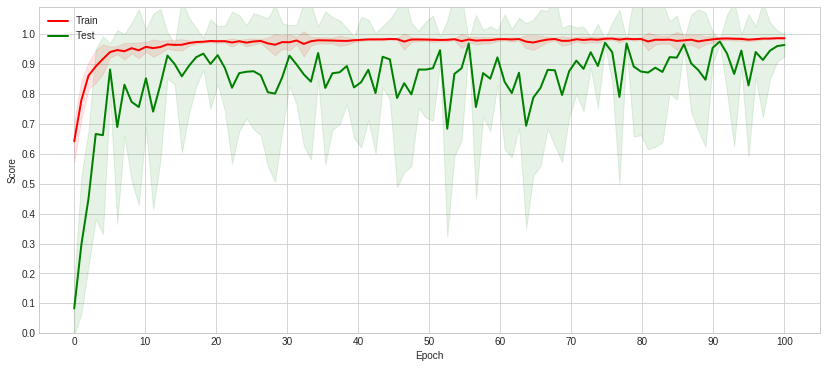

In [3]:
plot_mean_acc(history)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

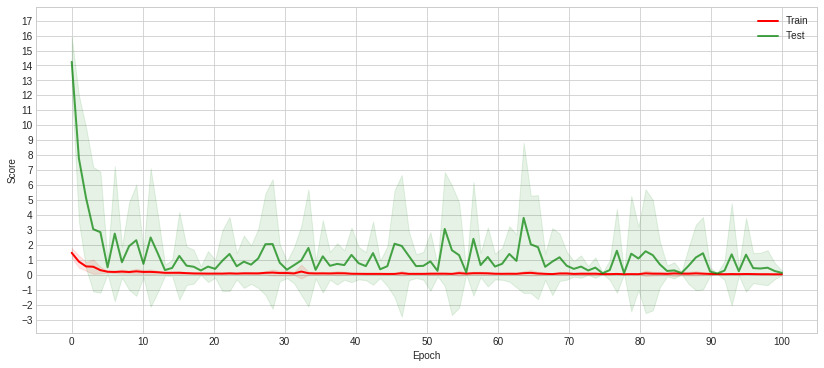

In [5]:
plot_mean_loss(history)